# Imports

In [127]:
# General Imports
import numpy as np
import pandas as pd
import statistics
import pickle
import os
from IPython.display import display
from collections import Counter

# Représentations graphiques
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('twilight', color_codes = True)
from mpl_toolkits.mplot3d import Axes3D
#!pip install squarify
import squarify
from math import pi

# Dates
import datetime
from datetime import datetime
from datetime import timedelta

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer

# Clustering
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score

#!pip install kneed
from kneed import KneeLocator

# PCA
from sklearn.decomposition import PCA
from matplotlib.patches import Circle

import warnings
warnings.simplefilter(action = 'ignore')

# Sommaire (pour jupyter notebook)
#!pip install jyquickhelper
#from jyquickhelper import add_notebook_menu
#add_notebook_menu()

# Set display preferences
pd.set_option('display.max_row', 250)
pd.set_option('display.max_column', 100)
#pd.set_option('display.precision', 5)

# segmentation RFM

In [3]:
########## Import des données ##########

#path = '/content/drive/MyDrive/OpenClassrooms/Projet5/' #-> pour colab
path = '' #-> en local

filepath = os.path.join(path, 'data/df_for_rfm')

with open(filepath, 'rb') as f:
    df_final = pickle.load(f)

df_final.head()

,customer_id,customer_unique_id,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_item_id,product_id,seller_id,price,freight_value,seller_city,seller_state,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,Count,product_category,review_time,order_time,delivery_error_time,order_preparation_time,delivery_time,shipping_limit_respect,purchase_time,purchase_year,purchase_month,purchase_dayofweek,purchase_day,purchase_hour,review,product_volume_cm3,distance
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,124.99,21.88,itaquaquecetuba,SP,41.0,1141.0,1.0,8683.0,1.0,credit_card,2.0,146.87,88b8b52d46df026a9d1ad2136a59b30b,4.0,1,"Travail de bureau, Industry & Construction",4.940741,8.812500,-10.558623,6.809549,1.991412,-0.809549,2017-05-16 15:05:35,2017.0,5.0,1.0,16.0,15.0,0,107136.0,228.795383
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,289.00,46.48,itajai,SC,43.0,1002.0,3.0,10150.0,1.0,credit_card,8.0,335.48,02fc48a9efa3e3d0f1a8ea26507eeec3,5.0,1,Maison & jardin,11.946863,16.661748,-7.471308,2.844757,13.809954,3.155243,2018-01-12 20:48:24,2018.0,1.0,4.0,12.0,20.0,0,53400.0,302.718580
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,1.0,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,139.94,17.79,itaquaquecetuba,SP,55.0,955.0,1.0,8267.0,1.0,credit_card,7.0,157.73,5ad6695d76ee186dc473c42706984d87,5.0,1,"Travail de bureau, Industry & Construction",0.507627,26.077153,1.749201,21.924884,3.144340,-5.924884,2018-05-19 16:07:45,2018.0,5.0,5.0,19.0,16.0,0,45968.0,29.146575
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,1.0,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,149.94,23.36,itaquaquecetuba,SP,48.0,1066.0,1.0,12160.0,1.0,credit_card,1.0,173.30,059a801bb31f6aab2266e672cab87bc5,5.0,1,"Travail de bureau, Industry & Construction",4.775544,14.998461,-12.330266,14.245405,0.695637,-0.285718,2018-03-13 16:06:38,2018.0,3.0,1.0,13.0,16.0,0,79968.0,18.117442
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,1.0,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,230.00,22.25,ibitinga,SP,61.0,407.0,1.0,5200.0,1.0,credit_card,8.0,252.25,8490879d58d6c5d7773f2739a03f089a,5.0,1,Maison & jardin,7.083241,11.461319,-5.127917,1.212396,10.235972,0.787604,2018-07-29 09:51:30,2018.0,7.0,6.0,29.0,9.0,1,23625.0,187.459595


In [4]:
df_final.isna().sum()

customer_id                      0
customer_unique_id               0
customer_city                    0
customer_state                   0
order_id                       625
order_status                   625
order_purchase_timestamp       625
order_item_id                 1278
product_id                    1278
seller_id                     1278
price                         1278
freight_value                 1278
seller_city                   1278
seller_state                  1278
product_name_lenght           2972
product_description_lenght    2972
product_photos_qty            2972
product_weight_g              1298
payment_sequential             628
payment_type                   628
payment_installments           628
payment_value                  628
review_id                     1602
review_score                  1602
Count                            0
product_category              2995
review_time                   1602
order_time                    3303
delivery_error_time 

In [5]:
########## Total price ##########
# Prix total = prix unitaire * quantité
df_final['total_price'] = df_final['price'] * df_final['order_item_id']

########## Recency ##########
# Recency = nombre de jours écoulés depuis dernier achat
# convertir date en datetime
df_final['order_purchase_timestamp'] = pd.to_datetime(df_final['order_purchase_timestamp'])

# dataset pas super récent -> on prend la date max + 1 jour à la place de la date d'aujourd'hui
now = df_final['order_purchase_timestamp'].max() + timedelta(days = 1)

In [6]:
########## créer RFM dataframe ##########

rfm = df_final.groupby('customer_id').agg({
    'order_purchase_timestamp' : lambda day : (now - day.max()).days, # pour avoir temps écoulé depuis commande
    'order_id': lambda num : len(num),
    'total_price': lambda price : price.sum()
})

# Renommer colonnes
rfm.columns = ['Recency', 'Frequency', 'Monetary']

rfm.head()

,Recency,Frequency,Monetary
customer_id,,,
00012a2ce6f8dcda20d059ce98491703,293.0,1,89.80
000161a058600d5901f007fab4c27140,414.0,1,54.90
0001fd6190edaaf884bcaf3d49edf079,552.0,1,179.99
0002414f95344307404f0ace7a26f1d5,383.0,1,149.90
000379cdec625522490c315e70c7a9fb,154.0,1,93.00


### Calculating RFM Score

In [7]:
rfm['Frequency'].unique()

array([ 1,  4,  2,  3,  6,  7,  5,  8, 10, 12, 11, 15, 38,  9, 16, 20, 63,
       24, 13, 21, 14, 26, 29, 22, 19])

In [8]:
# les quantiles sont des points de données qui divisent un ensemble de données en des fractions égales

# calculer les quartiles
statistics.quantiles(rfm['Frequency'])

# calculer quintiles ?
statistics.quantiles(rfm['Frequency'], n = 5)

[1.0, 1.0, 1.0, 1.0]

In [9]:
rfm['Frequency'].value_counts()

1     86557
2      9798
3      1554
4       829
6       277
5       242
7        47
8        40
12       21
10       17
9        13
11       11
15        6
24        5
14        5
13        4
20        3
21        3
16        2
22        2
29        1
38        1
26        1
63        1
19        1
Name: Frequency, dtype: int64

In [10]:
print("Le nombre de clients ayant commandé plus d'une fois est de : {:.2f} %".format(100*sum(rfm['Frequency'] > 1)/len(rfm)))

Le nombre de clients ayant commandé plus d'une fois est de : 12.96 %


In [11]:
def plot_hist(rfm, figsize = (12, 7)):

    plt.figure(1, figsize = figsize)

    for i, col in enumerate(rfm):
        plt.subplot(len(rfm.columns), 1, i + 1)
        plt.hist(rfm[col],
                 bins = int(1 + np.log2(len(rfm))),
                 label = 'skweness : ' + str(round(rfm[col].skew(), 2)),
                 density = True)
        plt.ylabel("Nombre de clients (%)")
        plt.xlabel(col)
        plt.legend()
    plt.show()

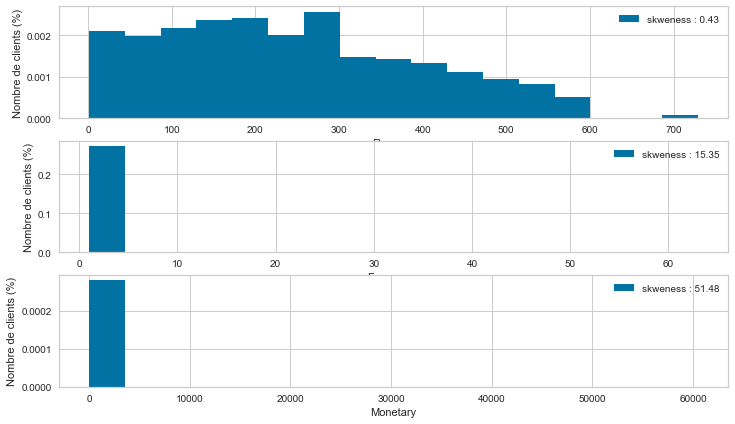

In [12]:
# Histogramme des variables 'Recency', 'Frequency' et 'Monetary'
plot_hist(rfm)

In [13]:
# Recency -> ok
# Frenquency et Monetary -> forte asymétrie
# passage au log pour corriger ça

In [14]:
# PASSAGE AU LOG

#https://github.com/MGL56/Projet_4/blob/master/Projet_4.ipynb


rfm[["Frequency", "Monetary"]] = rfm[["Frequency", "Monetary"]].apply(lambda x: np.log(1 + x))

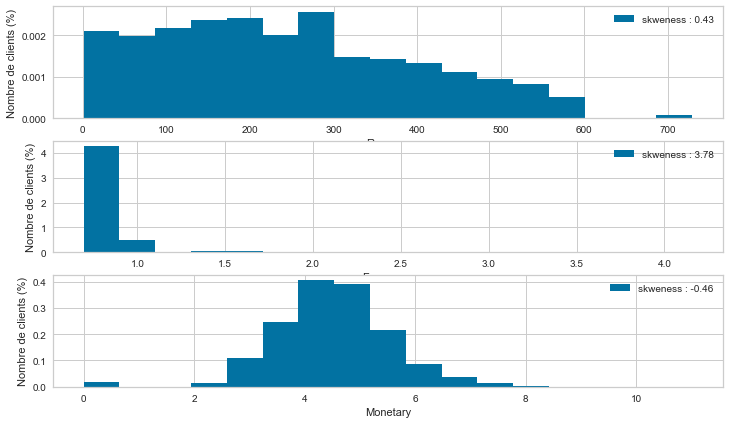

In [15]:
plot_hist(rfm)

In [16]:
# mieux - toujours pas fou pour frequency mais quand même mieux

In [17]:
# recency -> nombre inversés car plus c'est récent mieux c'est

# Customers with the lowest recency, highest frequency and monetary amounts considered as top customers.

# qcut() is Quantile-based discretization function. qcut bins the data based on sample quantiles.
# For example, 1000 values for 5 quantiles would produce a categorical object indicating quantile membership for
# each customer

"""

rfm["R"] = pd.qcut(rfm["Recency"], 5, labels = [5, 4, 3, 2, 1])
rfm["F"] = pd.qcut(rfm["Frequency"], 5, labels = [1, 2, 3, 4, 5])
rfm["M"] = pd.qcut(rfm["Monetary"], 5, labels = [1, 2, 3, 4, 5])
rfm["RFM_Score"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)

rfm.head()

"""

# -> ne fonctionne pas 
# ValueError: Bin edges must be unique: array([0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
#       4.15888308]).

'\n\nrfm["R"] = pd.qcut(rfm["Recency"], 5, labels = [5, 4, 3, 2, 1])\nrfm["F"] = pd.qcut(rfm["Frequency"], 5, labels = [1, 2, 3, 4, 5])\nrfm["M"] = pd.qcut(rfm["Monetary"], 5, labels = [1, 2, 3, 4, 5])\nrfm["RFM_Score"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)\n\nrfm.head()\n\n'

In [18]:
# autre méthode :

def r_score(x, quintiles):
    """
    Attribue une note entre 1 et 5 suivant l'emplacement de x par
    rapport aux quintiles. Plus la 'Recency' est faible, plus la note
    est élevé
    x(float): valeur
    quintiles(dict): voir fonction calculQuantile
    """

    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1


def fm_score(x, quintiles, c):
    """
    Attribue une note entre 1 et 5 suivant l'emplacement de x par
    rapport aux quintiles. Plus x est grand, plus la note est grande
    x(float): valeur
    quintiles(dict): voir fonction calculate_quantile
    """

    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5


def calculate_quantile(rfm):
    """
    Calcul des quantiles pour chaque variable Recency, Frequency et Monetary
    puis attribue un score (fm_score et r_score) suivant la valeur
    des variables de chaque individu
    rfm(pd.DataFrame): présente les colonnes 'Recency', 'Frequency' et Monetary
    """
    quintiles = rfm[['Recency',
                     'Frequency',
                     'Monetary']].quantile([.2, .4, .6, .8]).to_dict()

    rfm['R'] = rfm['Recency'].apply(lambda x:
                                    r_score(x, quintiles))
    rfm['F'] = rfm['Frequency'].apply(lambda x:
                                      fm_score(x, quintiles, 'Frequency'))
    rfm['M'] = rfm['Monetary'].apply(lambda x:
                                     fm_score(x, quintiles, 'Monetary'))
    return rfm

In [19]:
# Calcul des quantiles
calculate_quantile(rfm)

,Recency,Frequency,Monetary,R,F,M
customer_id,,,,,,
00012a2ce6f8dcda20d059ce98491703,293.0,0.693147,4.508659,2,1,3
000161a058600d5901f007fab4c27140,414.0,0.693147,4.023564,1,1,2
0001fd6190edaaf884bcaf3d49edf079,552.0,0.693147,5.198442,1,1,4
0002414f95344307404f0ace7a26f1d5,383.0,0.693147,5.016617,2,1,4
000379cdec625522490c315e70c7a9fb,154.0,0.693147,4.543295,4,1,3
...,...,...,...,...,...,...
fffecc9f79fd8c764f843e9951b11341,158.0,1.386294,5.110179,4,5,4
fffeda5b6d849fbd39689bb92087f431,104.0,0.693147,3.889777,4,1,2
ffff42319e9b2d713724ae527742af25,82.0,0.693147,5.302807,5,1,5


In [20]:
rfm.isna().sum()

Recency      625
Frequency      0
Monetary       0
R              0
F              0
M              0
dtype: int64

In [21]:
#### attention, données manquantes !...

In [22]:
rfm["RFM_Score"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)

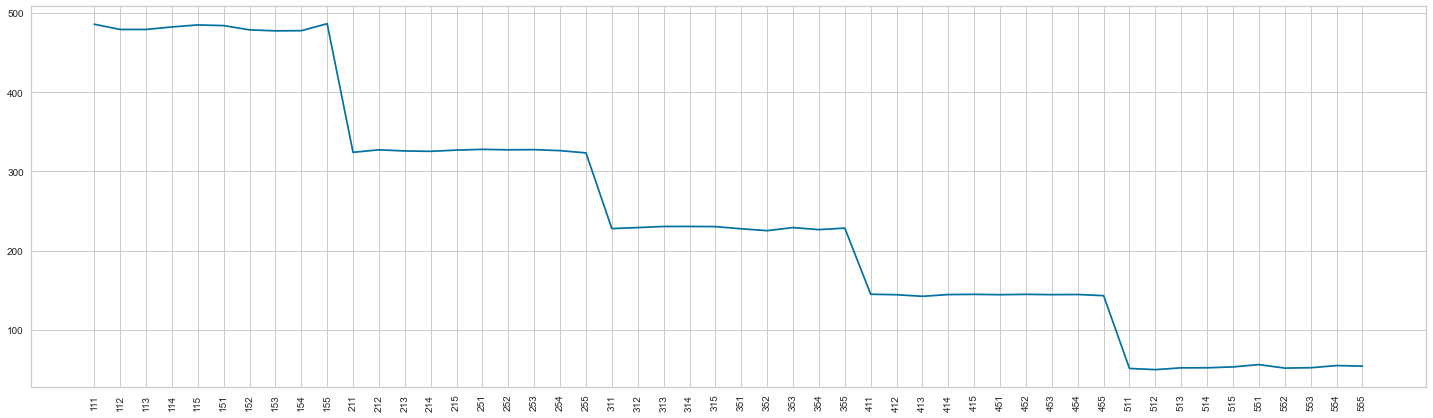

In [23]:
plt.figure(figsize = (25, 7))
plt.plot(rfm.groupby('RFM_Score').agg('Recency').mean())
plt.xticks(rotation = 90)
plt.show()

### Segmentation Customers

In [24]:
# exemples d'interprétation des segments RFM

#R=5, F=5, M=5 — they pay often, a lot and recently. The most loyal and active users.
#R=1, F=1, M=1 – they pay little, rarely and for a long time. Most likely lost customers. It may not be worth taking action to return them if the cost of attraction is higher than the expected profit.
#R=1/2, F=4/5, M=4/5 — loyal users on the verge of leaving. We offer them a bonus, a discount and try to return them.
#R=4/5, F=1, M=1/2/3/4/5 — Users have recently made a payment. We try to encourage them to buy more.

In [25]:
# use Recency and Frequency to segment our customers
# 10 segments based on the R and F scores

seg_map = {
    r'[1-2][1-2]': 'Hibernating', # Last purchase was long back and low number of orders. May be lost
    r'[1-2][3-4]': 'At Risk', # Purchased often but a long time ago. Need to bring them back!
    r'[1-2]5': 'Can\'t Loose', # Used to purchase frequently but haven’t returned for a long time
    r'3[1-2]': 'About to Sleep', # Below average recency and frequency. Will lose them if not reactivated
    r'33': 'Need Attention', # Above average recency, frequency and monetary values. May not have bought very recently though
    r'[3-4][4-5]': 'Loyal Customers', # Buy on a regular basis. Responsive to promotions
    r'41': 'Promising', # Recent shoppers, but haven’t spent much
    r'51': 'New Customers', # Bought most recently, but not often
    r'[4-5][2-3]': 'Potential Loyalists', # Recent customers with average frequency
    r'5[4-5]': 'Champions'    # Bought recently, buy often and spend the most
}

In [26]:
# determiner comment segmenter les clients en utilisant regex

rfm['Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str)
rfm['Segment'] = rfm['Segment'].replace(seg_map, regex = True)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment
customer_id,,,,,,,,
00012a2ce6f8dcda20d059ce98491703,293.0,0.693147,4.508659,2,1,3,213,Hibernating
000161a058600d5901f007fab4c27140,414.0,0.693147,4.023564,1,1,2,112,Hibernating
0001fd6190edaaf884bcaf3d49edf079,552.0,0.693147,5.198442,1,1,4,114,Hibernating
0002414f95344307404f0ace7a26f1d5,383.0,0.693147,5.016617,2,1,4,214,Hibernating
000379cdec625522490c315e70c7a9fb,154.0,0.693147,4.543295,4,1,3,413,Promising


In [27]:
# grouper données dans l'ordre pour voir la valeur moyenne de chaque segment
rfm.groupby('Segment').mean().sort_values('Monetary')

,Recency,Frequency,Monetary,R,F,M
Segment,,,,,,
Hibernating,403.925246,0.693147,4.273678,1.492587,1.0,2.768099
About to Sleep,229.605635,0.693147,4.363925,3.000000,1.0,2.818075
New Customers,51.491197,0.693147,4.405354,5.000000,1.0,2.843608
Promising,144.174771,0.693147,4.427693,4.000000,1.0,2.876101
Can't Loose,402.178807,1.220491,5.350457,1.510249,5.0,4.095900
Loyal Customers,184.929433,1.213446,5.392438,3.510575,5.0,4.182052
Champions,53.878441,1.211339,5.401688,5.000000,5.0,4.160949


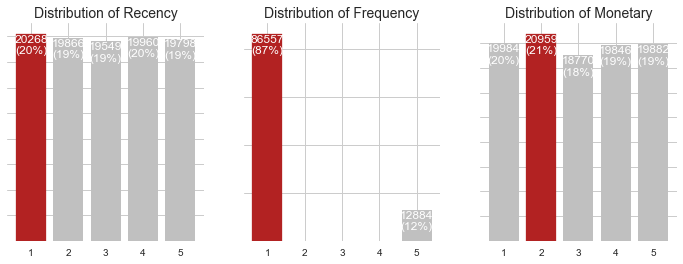

In [28]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

for i, p in enumerate(['R', 'F', 'M']):
    parameters = {'R':'Recency', 'F':'Frequency', 'M':'Monetary'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color = 'silver')
    ax.set_frame_on(False)
    ax.tick_params(left = False, labelleft = False, bottom = False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize = 14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha = 'center',
               va = 'top',
               color = 'w')

plt.show()

In [29]:
# recency et monetary sont distribués de façon relativement homogènes
# par contre frequency pas du tout

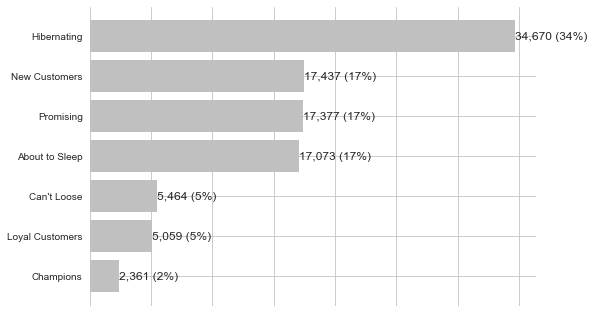

In [30]:
# count the number of customers in each segment
segments_counts = rfm['Segment'].value_counts().sort_values(ascending = True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color = 'silver')
ax.set_frame_on(False)
ax.tick_params(left = False,
               bottom = False,
               labelbottom = False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value), int(value*100/segments_counts.sum())),
                va = 'center',
                ha = 'left'
               )

plt.show()

In [31]:
group = rfm.groupby('Segment').mean().sort_values('Monetary')
group

,Recency,Frequency,Monetary,R,F,M
Segment,,,,,,
Hibernating,403.925246,0.693147,4.273678,1.492587,1.0,2.768099
About to Sleep,229.605635,0.693147,4.363925,3.000000,1.0,2.818075
New Customers,51.491197,0.693147,4.405354,5.000000,1.0,2.843608
Promising,144.174771,0.693147,4.427693,4.000000,1.0,2.876101
Can't Loose,402.178807,1.220491,5.350457,1.510249,5.0,4.095900
Loyal Customers,184.929433,1.213446,5.392438,3.510575,5.0,4.182052
Champions,53.878441,1.211339,5.401688,5.000000,5.0,4.160949


values = rfm['Segment'].value_counts().values
labels = rfm['Segment'].value_counts().index

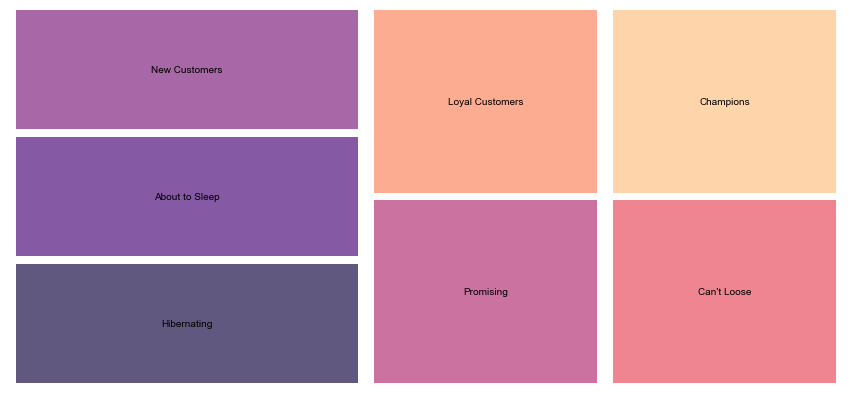

In [36]:
# Isoler valeurs et labels des clusters
values = group.index.value_counts().values
labels = group.index.value_counts().index

plt.figure(figsize = (15, 7))
squarify.plot(values,
              label = labels,
              text_kwargs = {'fontsize': 10, 'color': 'black'},
              pad = 0.20,
              color = sns.color_palette("magma", len(values)),
              alpha = 0.7)
plt.axis('off')
plt.show()

In [37]:
# interessant mais :
# - statique/figé -> on suppose que les clients segmentés vont maintenir leurs habitudes de consommation,
# qu'ils vont se comporter dans le futur comme ils se sont comportés dans le passé
# - méthode uniquement descriptive, ne fournit pas un moyen de prévision (contrairement à un modèle prédictif)

# frequence -> très faible pourcentage qui commande plus d'une fois donc pas
# avoir 5 groupes homogènes pour la fréquence -> super desequilibré

In [38]:
# Liste des fonctions d'aggrégation
func = ['count', 'min', 'mean', 'median', 'max', 'std']

# Regroupement des données
qtd_preco = rfm.groupby(['Segment'])

# Aggrégation des données par différentes fonctions
summery_table = qtd_preco[['Recency', 'Frequency', 'Monetary']].agg(func)

# Affichage de la table de résumé
summery_table

Recency                                             Frequency  \
                  count    min        mean median    max        std     count   
Segment                                                                         
About to Sleep    17073  187.0  229.605635  229.0  276.0  26.646168     17073   
Can't Loose        5464  277.0  402.178807  390.0  729.0  93.694631      5464   
Champions          2361    5.0   53.878441   51.0  102.0  26.578331      2361   
Hibernating       34045  277.0  403.925246  392.0  700.0  93.096954     34670   
Loyal Customers    5059  103.0  184.929433  185.0  276.0  49.038525      5059   
New Customers     17437    1.0   51.491197   47.0  102.0  26.456815     17437   
Promising         17377  103.0  144.174771  143.0  186.0  24.280977     17377   

                                                                  Monetary  \
                      min      mean    median       max       std    count   
Segment                                                                      
About to Sleep   0.693147  0.693147  0.693147  0.693147  0.000000    17073   
Can't Loose      1.098612  1.220491  1.098612  4.158883  0.262094     5464   
Champions        1.098612  1.211339  1.098612  3.091042  0.239210     2361   
Hibernating      0.693147  0.693147  0.693147  0.693147  0.000000    34670   
Loyal Customers  1.098612  1.213446  1.098612  3.218876  0.246844     5059   
New Customers    0.693147  0.693147  0.693147  0.693147  0.000000    17437   
Promising        0.693147  0.693147  0.693147  0.693147  0.000000    17377   

                                                               
                 min      mean    median        max       std  
Segment                                                        
About to Sleep   0.0  4.363925  4.394326   8.213653  0.954651  
Can't Loose      0.0  5.350457  5.284977  11.010085  1.015816  
Champions        0.0  5.401688  5.351716   9.792612  0.982275  
Hibernating      0.0  4.273678  4.356581   8.815222  1.175178  
Loyal Customers  0.0  5.392438  5.360729   9.952325  0.964442  
New Customers    0.0  4.405354  4.393214   8.814330  0.925607  
Promising        0.0  4.427693  4.450269   8.318984  0.934427

In [39]:
rfm = rfm.drop(["R", "F", "M", "RFM_Score"], axis = 1)
rfm

,Recency,Frequency,Monetary,Segment
customer_id,,,,
00012a2ce6f8dcda20d059ce98491703,293.0,0.693147,4.508659,Hibernating
000161a058600d5901f007fab4c27140,414.0,0.693147,4.023564,Hibernating
0001fd6190edaaf884bcaf3d49edf079,552.0,0.693147,5.198442,Hibernating
0002414f95344307404f0ace7a26f1d5,383.0,0.693147,5.016617,Hibernating
000379cdec625522490c315e70c7a9fb,154.0,0.693147,4.543295,Promising
...,...,...,...,...
fffecc9f79fd8c764f843e9951b11341,158.0,1.386294,5.110179,Loyal Customers
fffeda5b6d849fbd39689bb92087f431,104.0,0.693147,3.889777,Promising
ffff42319e9b2d713724ae527742af25,82.0,0.693147,5.302807,New Customers


In [40]:
rfm = rfm.reset_index(drop = True)
rfm

,Recency,Frequency,Monetary,Segment
0,293.0,0.693147,4.508659,Hibernating
1,414.0,0.693147,4.023564,Hibernating
2,552.0,0.693147,5.198442,Hibernating
3,383.0,0.693147,5.016617,Hibernating
4,154.0,0.693147,4.543295,Promising
...,...,...,...,...
99436,158.0,1.386294,5.110179,Loyal Customers
99437,104.0,0.693147,3.889777,Promising
99438,82.0,0.693147,5.302807,New Customers
99439,366.0,1.098612,3.517498,Can't Loose


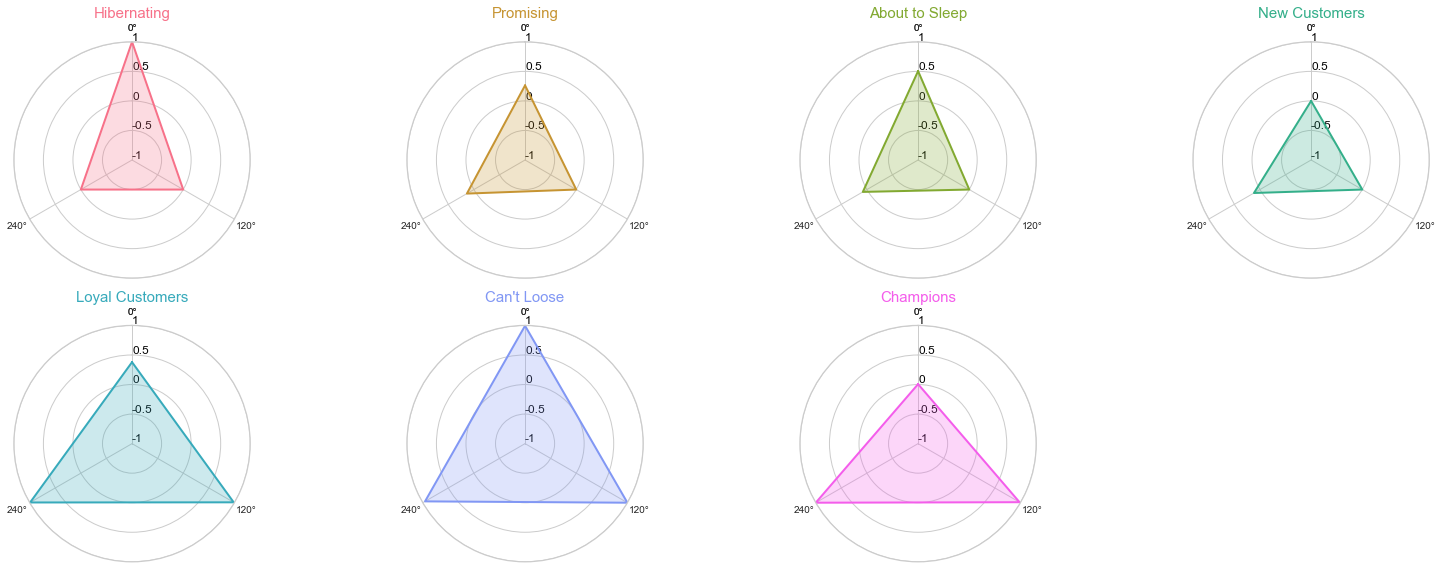

In [49]:
########## Radar plot ##########

# Lister les catégories de clients
categories = rfm['Segment'].unique()

# Liste des couleurs pour chaque segment
palette_1 = sns.color_palette('husl', len(categories))
colors_1 = {label: color for label, color in zip(categories, palette_1.as_hex())}
colors = colors_1

# Définir la taille du graph (nombre de subplots)
sub_plot = [4, 4]

# Aggrégation par moyenne des valeurs par segment
df_plot = rfm.groupby(['Segment']).agg('mean')

# Transformation MinMax -> [0, 1]
df_plot_std = pd.DataFrame(MinMaxScaler().fit_transform(df_plot),
                           columns = list(df_plot.columns),
                           index = df_plot.index)

# Noms des variables
categories = list(df_plot.columns)
# Nombre de variables
N = len(categories)

# Quel sera l'angle de chaque axe ?
# On divise un tour complet par le nombre de variables
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig = plt.figure(1, figsize = (27, 20)) # un peu gros, à réduire

# Trace un radar chart pour chaque segment
for i, segment in enumerate(rfm['Segment'].unique()):
    ax = fig.add_subplot(sub_plot[0], sub_plot[1], i + 1, polar = True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)

    # Draw one axe per variable + add labels labels yet
    plt.yticks(color = 'grey', size = 2)
    values = list(df_plot_std.loc[segment].values)
    values += values[:1]
    ax.plot(angles, values, colors[segment],
            'o-', linewidth = 2, linestyle = 'solid')
    ax.fill(angles, values, colors[segment], alpha = 0.25)
    ax.set_xticks(angles)
    plt.yticks([-1, -0.5, 0, 0.5, 1],
               ['-1', '-0.5', '0', '0.5', '1'],
               color = 'black',
               size = 12)
    ax.set_title(segment, size = 15, color = colors[segment])
    ax.grid(True)
    plt.ylim(-1, 1)

plt.show()

In [ ]:
########## CONCLUSION ##########

# Segmentation RFM ne suffit pas à différentier blablabla

# Autres méthodes de segmentation -> clustering

## Import des données avec d'autres variables

In [128]:
########## Import des données ##########

# Chemin d'accès aux données (à modifier si code en local)
#path = '/content/drive/MyDrive/OpenClassrooms/Projet5/' #-> pour colab
path = '' #-> en local

filepath = os.path.join(path, 'data/df')

with open(filepath, 'rb') as f:
    df_final = pickle.load(f)

df_final.head()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,payment_sequential,payment_installments,payment_value,review_score,review_time,order_time,delivery_error_time,order_preparation_time,shipping_limit_respect,review,distance,Count,order_item_id,customer_city,customer_state,order_status,payment_type,purchase_year,purchase_month,purchase_dayofweek,purchase_day,purchase_hour,product_category_,product_category_Eletronique et Divertissement,"product_category_Fashion, Beauté & Santé",product_category_Maison & jardin,"product_category_Travail de bureau, Industry & Construction"
0,1.063188,-0.700735,-0.108160,0.048224,-0.129527,-0.710341,-0.091387,0.695489,-0.267386,1.222596,0.716321,0.667666,-0.513630,-0.785479,0.199747,-0.276885,1.498106,0,0,1,1,2017.0,11.0,3.0,30.0,21.0,0,0,0,1,0
1,-0.612718,0.283910,-0.108160,-0.292761,-0.129527,-0.710341,-0.593578,-0.881828,0.092191,0.090963,-0.143778,0.878969,-0.738063,-0.785479,0.012270,-0.276885,-0.294658,0,0,1,1,2017.0,10.0,6.0,29.0,18.0,0,0,1,0,0
2,0.329979,-0.374186,-0.731241,-0.564916,-0.129527,0.090768,-0.704357,0.695489,-0.018267,-0.408620,-3.131374,0.055024,1.013581,0.722476,-0.078750,-0.276885,-0.294658,0,0,1,1,2018.0,5.0,0.0,7.0,0.0,0,0,0,0,1
3,-2.393368,1.171924,-0.731241,-0.235798,-0.129527,2.093542,-0.054668,-0.093169,0.318917,-0.988385,-0.682080,-0.604077,0.552805,-0.785479,-0.111290,-0.276885,-0.294658,0,0,1,1,2017.0,8.0,6.0,27.0,21.0,0,1,0,0,0
4,0.434724,2.902968,-0.731241,-0.604474,-0.129527,-0.710341,-0.784797,0.695489,-0.349595,-0.080939,-1.917203,0.682182,-1.168344,0.722476,-1.118441,-0.276885,-0.294658,0,0,1,1,2017.0,1.0,3.0,5.0,13.0,0,1,0,0,0


In [129]:
df_final.shape

(87769, 31)

# Jeu de données réduit

## Choix variables

In [130]:
# Lister les colonnes du df
df_final.columns

Index(['product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'payment_sequential',
       'payment_installments', 'payment_value', 'review_score', 'review_time',
       'order_time', 'delivery_error_time', 'order_preparation_time',
       'shipping_limit_respect', 'review', 'distance', 'Count',
       'order_item_id', 'customer_city', 'customer_state', 'order_status',
       'payment_type', 'purchase_year', 'purchase_month', 'purchase_dayofweek',
       'purchase_day', 'purchase_hour', 'product_category_',
       'product_category_Eletronique et Divertissement',
       'product_category_Fashion, Beauté & Santé',
       'product_category_Maison & jardin',
       'product_category_Travail de bureau, Industry & Construction'],
      dtype='object')

In [131]:
df_final.reset_index(drop = True, inplace = True)

In [132]:
# reconstituer date d'achat
df_final['Date_achat'] = df_final.apply(lambda row: datetime.strptime(f"{int(row.purchase_year)}-{int(row.purchase_month)}-{int(row.purchase_day)}", '%Y-%m-%d'), axis = 1)
df_final['Date_achat']

0       2017-11-30
1       2017-10-29
2       2018-05-07
3       2017-08-27
4       2017-01-05
           ...    
87764   2018-04-30
87765   2017-12-15
87766   2018-05-07
87767   2017-06-15
87768   2017-05-03
Name: Date_achat, Length: 87769, dtype: datetime64[ns]

In [133]:
# Choix des variables (d'après résultats des analyses precedantes) :
# (garder nb de commandes et nb de produits/commandes séparés)

df_reduit = df_final[[
    'Count',
    'order_item_id',
    #'product_name_lenght',
    'product_description_lenght',
    #'product_photos_qty',
    'product_weight_g',
    'payment_sequential', # nb de types de paiement
    'payment_installments', # paiement en plusieurs fois
    'payment_value',
    #'review_score',
    #'review_time',
    #'order_time',
    #'delivery_error_time',
    #'order_preparation_time',
    #'shipping_limit_respect',
    #'purchase_month',
    #'purchase_dayofweek',
    #'purchase_day',
    #'purchase_hour',
    'review',
    #'distance'
    ]]

In [56]:
df_reduit.columns

Index(['Count', 'order_item_id', 'product_description_lenght',
       'product_weight_g', 'payment_sequential', 'payment_installments',
       'payment_value', 'review'],
      dtype='object')

In [134]:
df_reduit.reset_index(drop = True, inplace = True)

In [135]:
df_reduit

,Count,order_item_id,product_description_lenght,product_weight_g,payment_sequential,payment_installments,payment_value,review
0,-0.276885,1.498106,-0.700735,0.048224,-0.129527,-0.710341,-0.091387,-0.785479
1,-0.276885,-0.294658,0.283910,-0.292761,-0.129527,-0.710341,-0.593578,-0.785479
2,-0.276885,-0.294658,-0.374186,-0.564916,-0.129527,0.090768,-0.704357,0.722476
3,-0.276885,-0.294658,1.171924,-0.235798,-0.129527,2.093542,-0.054668,-0.785479
4,-0.276885,-0.294658,2.902968,-0.604474,-0.129527,-0.710341,-0.784797,0.722476
...,...,...,...,...,...,...,...,...
87764,0.943457,2.394489,-0.320872,0.305347,-0.129527,-0.309787,1.409325,2.230432
87765,-0.276885,-0.294658,-1.168900,0.463577,-0.129527,-0.309787,-0.646893,-0.785479
87766,-0.276885,-0.294658,-1.068936,-0.386908,-0.129527,-0.309787,-0.612819,0.722476
87767,-0.276885,-0.294658,-0.720728,-0.457716,-0.129527,0.891878,1.554231,0.722476


## Kmeans

### Choix du K optimal

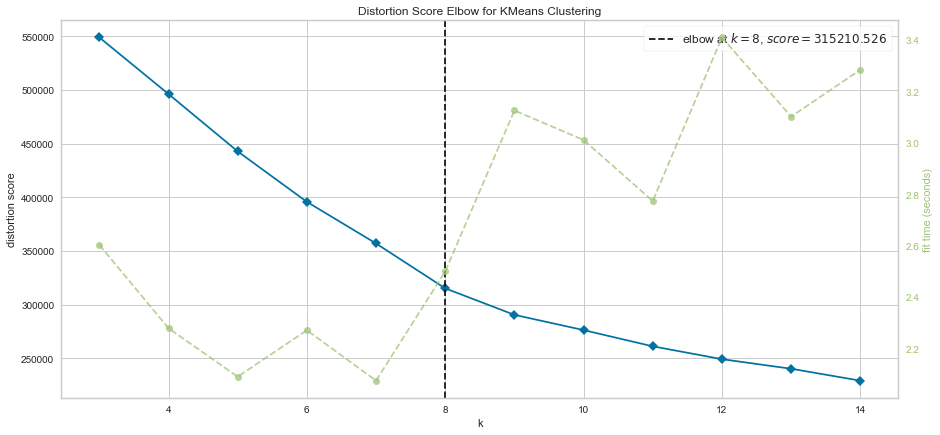

CPU times: user 2min 28s, sys: 1min 23s, total: 3min 52s
Wall time: 33 s


<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [59]:
%%time

# KElbowVisualizer - 'distortion' metric (default metric)
# Instantiate the clustering model and visualizer
model = KMeans()
d_visualizer = KElbowVisualizer(
    model,
    k = (3, 15),
    size = (1080, 500),
    metric = 'distortion'
    )

# Fit the data to the visualizer
d_visualizer.fit(df_reduit)

# Finalize and render the figure
d_visualizer.show()

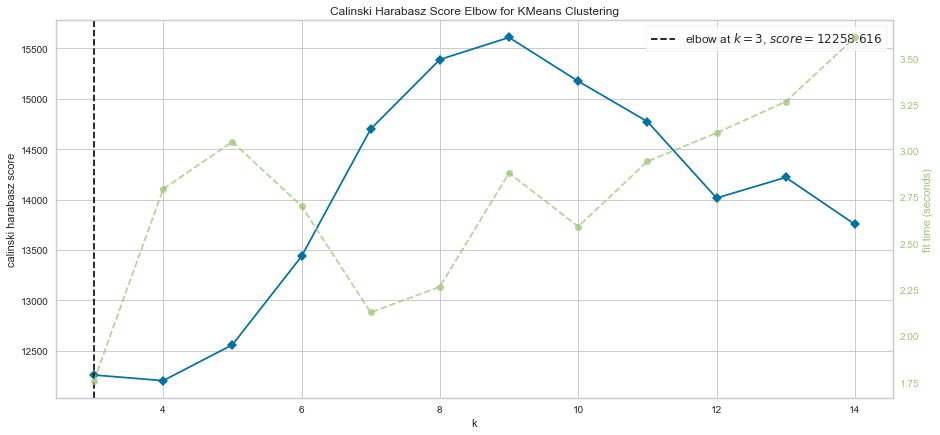

CPU times: user 2min 15s, sys: 1min 40s, total: 3min 56s
Wall time: 33.3 s


<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [60]:
%%time

# KElbowVisualizer - 'calinski_harabasz' metric
# Instantiate the clustering model and visualizer
model = KMeans()
ch_visualizer = KElbowVisualizer(
    model,
    k = (3, 15),
    size = (1080, 500),
    metric = 'calinski_harabasz'
    )

# Fit the data to the visualizer
ch_visualizer.fit(df_reduit)

# Finalize and render the figure
ch_visualizer.show()   

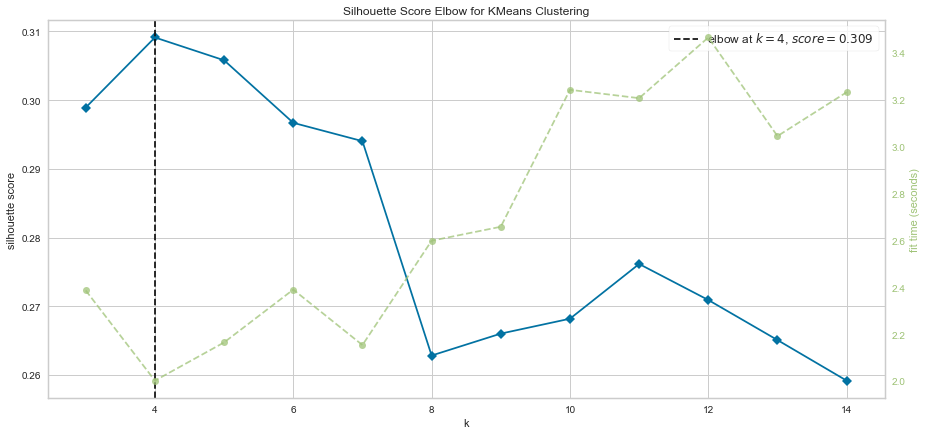

CPU times: user 32min 12s, sys: 11min 45s, total: 43min 58s
Wall time: 12min 59s


<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [61]:
%%time

# KElbowVisualizer - 'silhouette' metric (le plus long)
# Instantiate the clustering model and visualizer
model = KMeans()
s_visualizer = KElbowVisualizer(
    model,
    k = (3, 15),
    size = (1080, 500),
    metric = 'silhouette'
    )

# Fit the data to the visualizer
s_visualizer.fit(df_reduit)

# Finalize and render the figure
s_visualizer.show()

In [62]:
# Comparer le k optimal des différentes métriques :

# distortion
k_distortion = d_visualizer.elbow_value_
print(f'Nombre optimal de clusters - distortion metric : k = {k_distortion}')

# calinski harabasz
k_calinski_harabasz = ch_visualizer.elbow_value_
print(f'Nombre optimal de clusters - calinski harabasz metric : k = {k_calinski_harabasz}')

# silhouette
k_silhouette = s_visualizer.elbow_value_
print(f'Nombre optimal de clusters - silhouette metric : k = {k_silhouette}')

Nombre optimal de clusters - distortion metric : k = 8
Nombre optimal de clusters - calinski harabasz metric : k = 3
Nombre optimal de clusters - silhouette metric : k = 4


In [65]:
########## Choix de k ##########

# test avec 3
k = 3
#silhouette_kmeans = 0.37

# test avec 7
#k = 7
#silhouette_kmeans = 0.37

# d'après le graph, le max semble plutôt être atteint avec k = 4
#k = 4
#silhouette_kmeans = 0.38

### Kmeans clustering

In [66]:
# faire une gridsearch ? -> OUI

In [67]:
%%time

# Instantiate the clustering model
model = KMeans(
    n_clusters = k # nb de clusters qu'on veut avoir
    #n_init = 10, # nb d'initialisations qu'on veut faire - 10 = valeur par défaut
    # #max_iter = 300, # nb d'itérations max - par défaut 300
    # #init = 'k-means++'' # quelle stratégie d'initialisation on utilise
    )

# K-Means++ -> méthode d'initialisation qui consiste à placer les centroïdes sur des points du dataset éloignés les uns des autres - facilite convergence

# Entrainer le modèle
model.fit(df_reduit)
# model.labels_ ou
model.predict(df_reduit)

CPU times: user 8.15 s, sys: 4.11 s, total: 12.3 s
Wall time: 1.94 s


array([0, 0, 0, ..., 0, 2, 0], dtype=int32)

In [68]:
# Centroids (= centres des clusters)
centroids = model.cluster_centers_
centroids

array([[-1.38133111e-01, -1.22790168e-01, -2.71184931e-02,
        -2.70980207e-01,  3.87582428e-02, -4.05451226e-01,
        -2.93867378e-01, -1.12511845e-01],
       [ 3.27908226e+00,  1.73740317e-01,  1.26072911e-03,
         2.37024669e-02, -3.30995854e-02,  4.29487118e-02,
         2.67933121e+00,  2.16305207e+00],
       [-1.06745025e-01,  3.47959986e-01,  8.28431977e-02,
         8.26012529e-01, -1.13344625e-01,  1.23470326e+00,
         4.67065209e-01, -4.90396680e-03]])

In [69]:
centroids.shape

(3, 8)

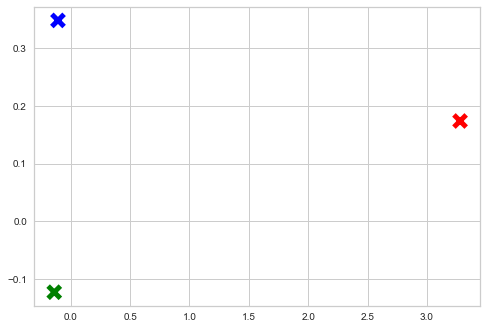

In [70]:
# Plot centroids
plt.figure()
plt.scatter(centroids[:,0], centroids[:,1], marker = 'x', s = 150, linewidths = 5, zorder = 10, c = ['green', 'red', 'blue'])
plt.show()

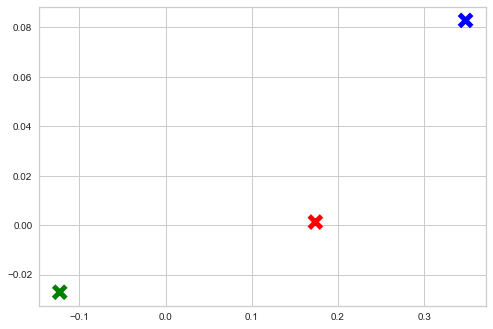

In [74]:
plt.figure()
plt.scatter(centroids[:,1], centroids[:,2], marker = 'x', s = 150, linewidths = 5, zorder = 10, c = ['green', 'red', 'blue'])
plt.show()

In [71]:
########## SILHOUETTE SCORE ##########
# pour évaluer le clustering
# A score closer to 1 indicates that the clustering is good, while a score closer to -1 indicates that the clustering is bad.
silhouette_kmeans = round(silhouette_score(df_reduit, model.fit_predict(df_reduit)), 2)
print('The average silhouette score is:', silhouette_kmeans)

The average silhouette score is: 0.3


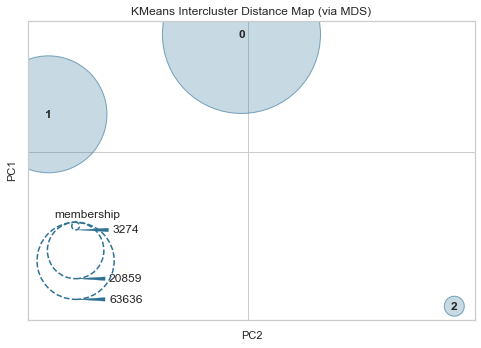

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [72]:
########## Distance intercluster ##########
# Intercluster distance Map with best k

distance_visualizer = InterclusterDistance(KMeans(k))
distance_visualizer.fit(df_reduit)
distance_visualizer.show()

In [73]:
########## CONCLUSIONS ##########
# Silhouette score de 0.35 -> acceptable
# 3 clusters bien distincts
# un des 3 clusters semble bien plus petit que les autres (en terme d'effectif)

### Description des clusters

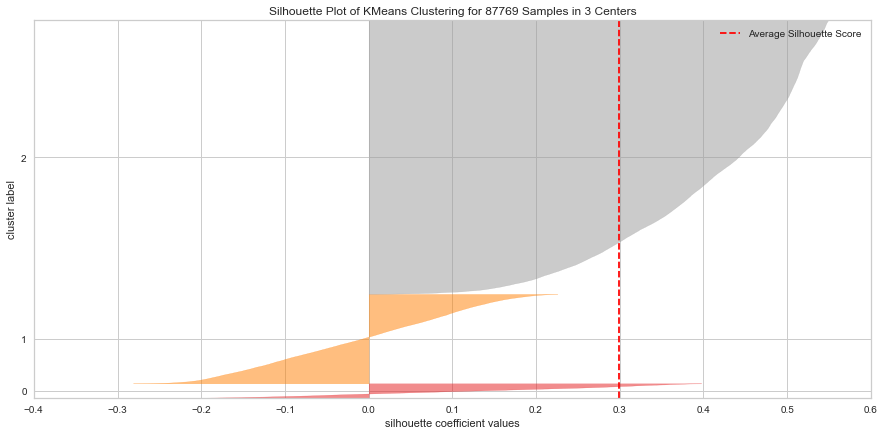

CPU times: user 5min 16s, sys: 2min 6s, total: 7min 23s
Wall time: 2min 11s


<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 87769 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [75]:
%%time
########## Visualisation des clusters ##########

# Instantiate the clustering model and visualizer
kmeans1 = KMeans(n_clusters = k, init = 'k-means++', random_state = 42)
visualizer = SilhouetteVisualizer(kmeans1, size = (1080, 500))

# Fit the data to the visualizer
visualizer.fit(df_reduit)

# Finalize and render the figure
visualizer.show()

In [76]:
# un cluster bien plus gros que les autres -> surement possible de le diviser si on améliore le clustering ?

In [77]:
# Créer une copie du df pour ajouter les clusters et observer leur comportement
df_clusters = df_reduit

labels = model.labels_
df_clusters['cluster_num'] = labels
df_clusters.head()

,Count,order_item_id,product_description_lenght,product_weight_g,payment_sequential,payment_installments,payment_value,review,cluster_num
0,-0.276885,1.498106,-0.700735,0.048224,-0.129527,-0.710341,-0.091387,-0.785479,1
1,-0.276885,-0.294658,0.283910,-0.292761,-0.129527,-0.710341,-0.593578,-0.785479,1
2,-0.276885,-0.294658,-0.374186,-0.564916,-0.129527,0.090768,-0.704357,0.722476,1
3,-0.276885,-0.294658,1.171924,-0.235798,-0.129527,2.093542,-0.054668,-0.785479,2
4,-0.276885,-0.294658,2.902968,-0.604474,-0.129527,-0.710341,-0.784797,0.722476,1


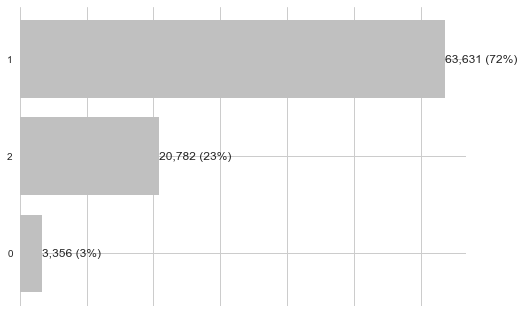

In [78]:
# Nombre de clients dans chaque cluster
segments_counts = df_clusters['cluster_num'].value_counts().sort_values(ascending = True)

# Plot
fig, ax = plt.subplots()
bars = ax.barh(
        range(len(segments_counts)),
        segments_counts,
        color = 'silver'
        )
ax.set_frame_on(False)
ax.tick_params(left = False, bottom = False, labelbottom = False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)
for i, bar in enumerate(bars):
        value = bar.get_width()
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value), int(value*100/segments_counts.sum())),
                va = 'center',
                ha = 'left'
               )
plt.show()

In [79]:
# Attention au volume des clusters
# si cluster avec moins de 500 individus -> risqué - clustering à revoir

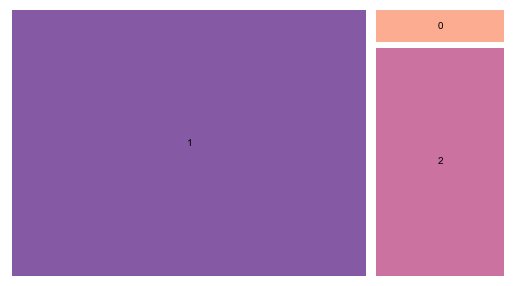

In [80]:
#Autre forme de visualisation

# Isoler valeurs et labels des clusters
values = df_clusters['cluster_num'].value_counts().values
labels = df_clusters['cluster_num'].value_counts().index

# Squarify plot
plt.figure(figsize = (9, 5))
squarify.plot(
    values,
    label = labels,
    text_kwargs = {'fontsize': 10, 'color': 'black'},
    pad = 0.20,
    color = sns.color_palette('magma', len(values)),
    alpha = 0.7
    )
plt.axis('off')
plt.show()

In [81]:
# Faire la moyenne pour expliquer les clusters
df_clusters.groupby('cluster_num').mean().reset_index(drop = True)

,Count,order_item_id,product_description_lenght,product_weight_g,payment_sequential,payment_installments,payment_value,review
0,3.279778,0.173079,0.001527,0.023731,-0.033071,0.042934,2.679807,2.163032
1,-0.138129,-0.122841,-0.027161,-0.270977,0.038764,-0.405461,-0.293908,-0.112538
2,-0.106711,0.348169,0.082915,0.825853,-0.113347,1.234519,0.467147,-0.004726


In [82]:
df_clusters.columns

Index(['Count', 'order_item_id', 'product_description_lenght',
       'product_weight_g', 'payment_sequential', 'payment_installments',
       'payment_value', 'review', 'cluster_num'],
      dtype='object')

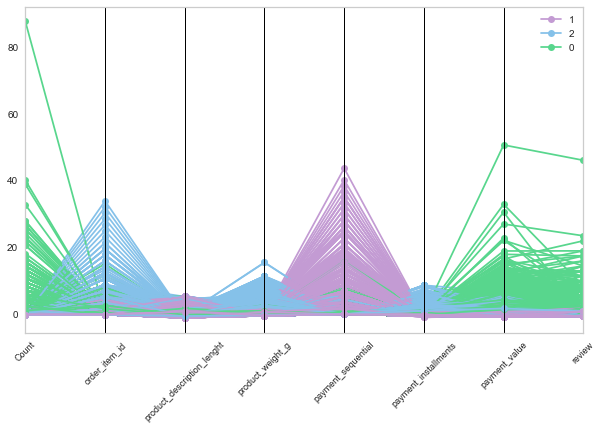

In [83]:
# Parallel_coordinates plot
# FAIRE PHRASE POUR EXPLIQUER CE QUE C'EST
# https://www.data-to-viz.com/graph/parallel.html

plt.figure(figsize = (10, 6))
pd.plotting.parallel_coordinates(df_clusters, 'cluster_num', marker = 'o', color = ['#c39bd3', '#85c1e9', '#58d68d'])
plt.xticks(fontsize = 9, rotation = 45)
plt.show()

In [84]:
# Grouper les données par cluster en ne gardant que la moyenne
mean = df_clusters.groupby('cluster_num').mean()
mean['cluster_num'] = mean.index
mean

,Count,order_item_id,product_description_lenght,product_weight_g,payment_sequential,payment_installments,payment_value,review,cluster_num
cluster_num,,,,,,,,,
0,3.279778,0.173079,0.001527,0.023731,-0.033071,0.042934,2.679807,2.163032,0
1,-0.138129,-0.122841,-0.027161,-0.270977,0.038764,-0.405461,-0.293908,-0.112538,1
2,-0.106711,0.348169,0.082915,0.825853,-0.113347,1.234519,0.467147,-0.004726,2


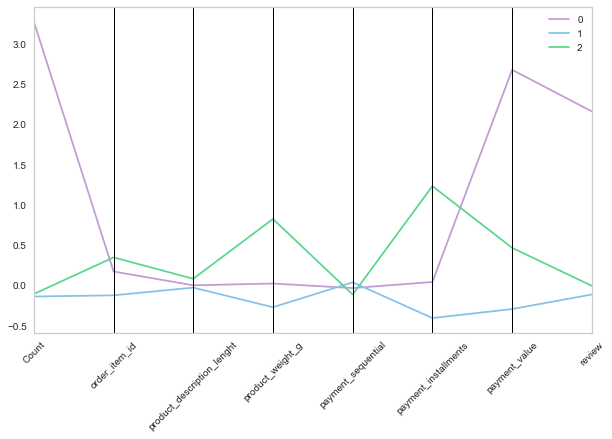

In [85]:
# Parallel_coordinates plot

plt.figure(figsize = (10, 6))
pd.plotting.parallel_coordinates(mean, 'cluster_num', color = ['#c39bd3', '#85c1e9', '#58d68d'])
plt.xticks(fontsize = 10, rotation = 45)
plt.show()

<Figure size 864x864 with 0 Axes>

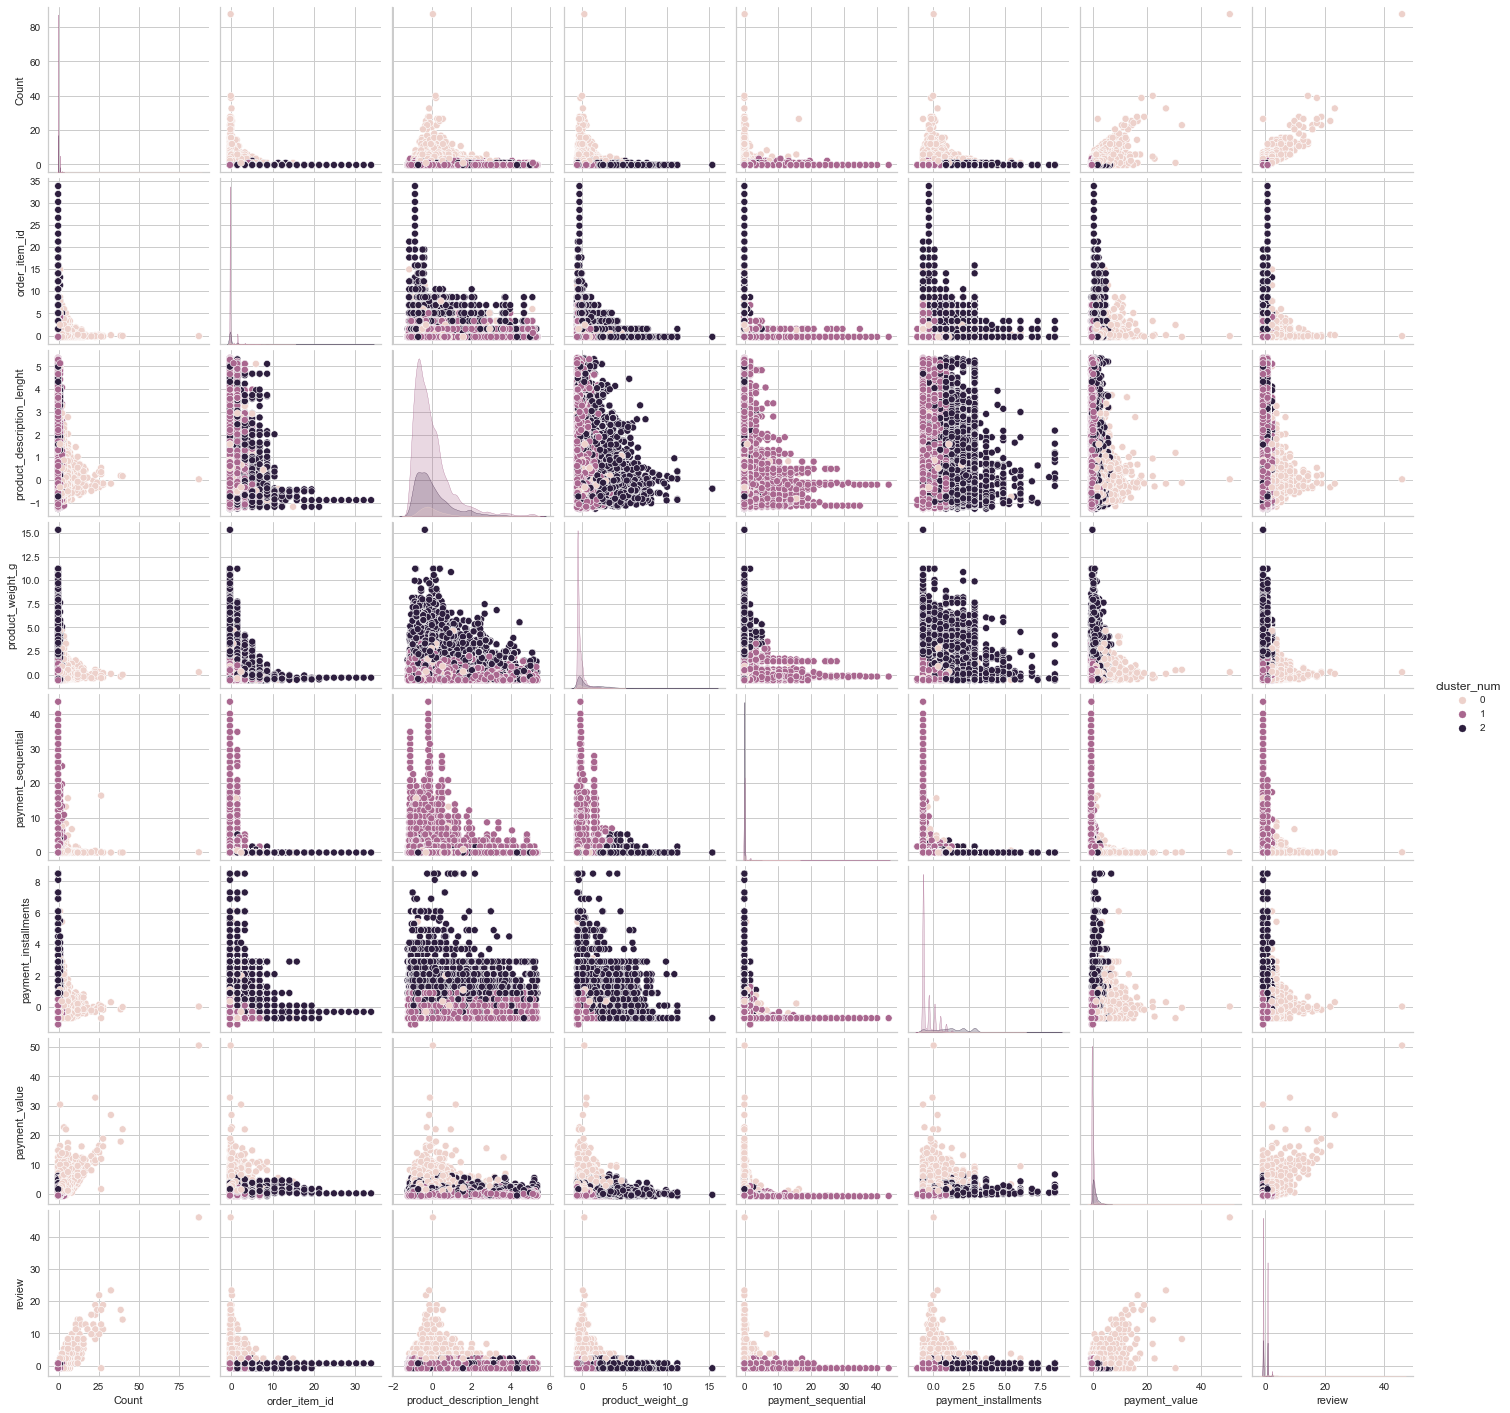

In [86]:
# Pairplot
plt.figure(figsize = (12, 12))
sns.pairplot(df_clusters, hue = 'cluster_num')
plt.show()

In [87]:
# Vulgariser les types de clusters -> pouvoir dire 'tel type de client a tel profil' etc
# faire boxplots par variables par clusters pour expliquer clusters

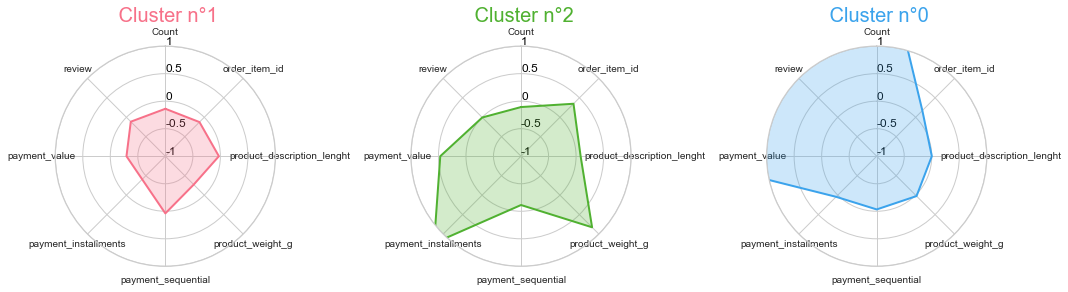

In [88]:
########## Radar plot ##########

clusters_customers = df_clusters['cluster_num'].unique()

# Liste des couleurs pour chaque segment
palette_1 = sns.color_palette('husl', len(clusters_customers))
colors = {label: color for label, color in zip(clusters_customers, palette_1.as_hex())}

# Aggrégation par moyenne des valeurs par segment (A faire pour aller plus loin -> trouver un autre moyen d'agg que la moyenne)
df_plot = df_clusters.groupby(['cluster_num']).agg('mean')

# Noms des variables
categories = list(df_plot.columns)

# Nombre de variables
N = len(categories)

# Définir l'angle entre chaque axe
# -> On divise un tour complet par le nombre de variables
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig = plt.figure(1, figsize = (15, 15))

# Trace un radar chart pour chaque segment
for i, segment in enumerate(df_clusters['cluster_num'].unique()):
    ax = fig.add_subplot(1, 3, i + 1, polar = True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)

    # Tracer un axe par variable et ajouter les labels
    plt.xticks(angles[:-1], categories)
    plt.yticks(color = 'grey', size = 2)
    values = list(df_plot.loc[segment].values)
    values += values[:1]
    ax.plot(angles, values, colors[segment], 'o-', linewidth = 2, linestyle = 'solid')
    ax.fill(angles, values, colors[segment], alpha = 0.25)
    plt.yticks([-1, -0.5, 0, 0.5, 1], ['-1', '-0.5', '0', '0.5', '1'], color = 'black', size = 12)
    ax.set_title(f' Cluster n°{segment}', size = 20, color = colors[segment])
    ax.grid(True)
    plt.ylim(-1, 1)
plt.tight_layout()
plt.show()

In [89]:
############ Description des différents clusters ##########

#### Cluster 1 = plus gros cluster, regroupe plus de 50% des clients

# Clients 'occasionnels' 
# -> commandent 1 fois 1 produit pas cher pas lourd, paient en une fois, ne laissent pas de review

#### CLuster 2

# Clients 'testeurs'/'influenceurs'
# clients qui dépensent un peu plus que les occasionnels
# vont commander quelques produits sans dépenser trop et laissser leur avis

#### Cluster 0

# Client 'fidèles'/'réguliers'
# achètent des produits les plus couteux et les plus volumineux - paient en plusieurs fois, avec un seul type de paiement (carte bleue) 
# dépensent le plus d'argent
# vont payer en plusieurs fois, commander des articles dans une autre ville


In [90]:
df_clusters.columns

Index(['Count', 'order_item_id', 'product_description_lenght',
       'product_weight_g', 'payment_sequential', 'payment_installments',
       'payment_value', 'review', 'cluster_num'],
      dtype='object')

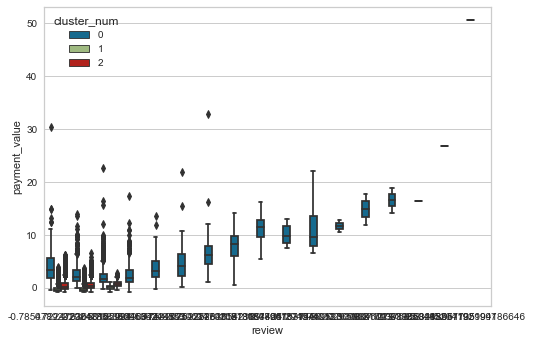

In [91]:
# Boxplot temps de livraison vs reviews
plt.figure()
sns.boxplot(
    x = 'review',
    y = 'payment_value',
    data = df_clusters,
    hue = 'cluster_num'
    )
plt.show()

In [92]:
# A FAIRE !!!!!!!!!!!!!!!!!!!
# Nommer les clusters
"""
df_clusters.rename({0:'well-off',
                         1:'fewer-opportunities',
                         2:'standard',
                         3:'career focused'})"""

"\ndf_clusters.rename({0:'well-off',\n                         1:'fewer-opportunities',\n                         2:'standard',\n                         3:'career focused'})"

In [93]:
# faire boucle pour faire les plots

# sinon, prendre les variables qui ont l'air le plus intéressantes pour expliquer les clusters

ValueError: Item wrong length 3 instead of 87769.

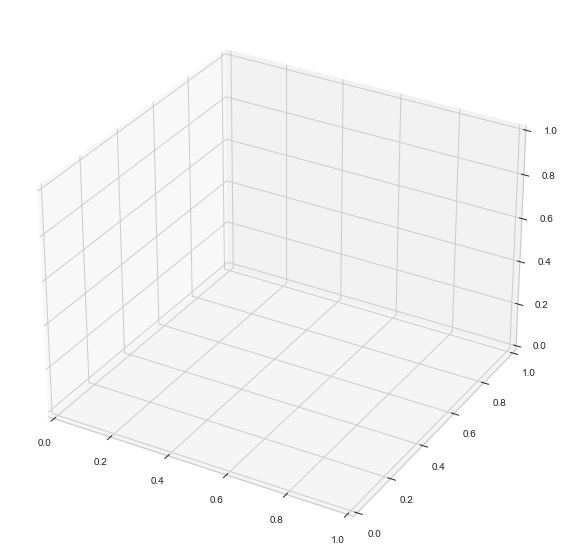

In [94]:
########## 3d-plot ##########

fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111, projection = '3d')

x = np.array(labels == 0)
y = np.array(labels == 1)
z = np.array(labels == 2)

ax.scatter(df_clusters[x]['payment_value'], df_clusters[x]['purchase_hour'], df_clusters[x]['full_written_review'], color = 'red')
ax.scatter(df_clusters[y]['payment_value'], df_clusters[y]['purchase_hour'], df_clusters[y]['full_written_review'], color = 'blue')
ax.scatter(df_clusters[z]['payment_value'], df_clusters[z]['purchase_hour'], df_clusters[z]['full_written_review'], color = 'yellow')
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c = 'black', s = 150, label = 'Center', alpha = 1)

In [ ]:
# 3d-plot

fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111, projection = '3d')

x = np.array(labels == 0)
y = np.array(labels == 1)
z = np.array(labels == 2)

ax.scatter(df_clusters[x]['full_written_review'], df_clusters[x]['order_time'], df_clusters[x]['payment_value'], color = 'red')
ax.scatter(df_clusters[y]['full_written_review'], df_clusters[y]['order_time'], df_clusters[y]['payment_value'], color = 'blue')
ax.scatter(df_clusters[z]['full_written_review'], df_clusters[z]['order_time'], df_clusters[z]['payment_value'], color = 'yellow')
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c = 'black', s = 150, label = 'Center', alpha = 1)

In [ ]:
# TO DO :
# terminer de tester les autres modèles (aglomerative)
# aller plus loin dans le feature eng -> le but est à la fin de pouvoir expliquer le comportement des clients
# faire mon acp et aller jusqu'au cercle des corrélations -> prendre les variables qui ont des grands vecteurs
# catégories de produits -> faire le mapping vers des catégories plus pertinentes (chatgpt)

# faire un premier choix arbitraire et en fonction des résultats je peux identifier les variables qui sont vraiment pertinentes ou non etc

# finir de tester mes différents modèles, les comparer et choisir le meilleur
# avoir une description vulgarisée du comportement des clients de chaque cluster

# Cluster interpretation

# https://python.plainenglish.io/a-comprehensive-guide-to-customer-segmentation-in-python-with-kmeans-a04068f8c3c

# https://www.kaggle.com/code/karnikakapoor/customer-segmentation-clustering
# à lire

## Agglomerative clustering

In [ ]:
# agglomerative clustering vs kmeans

# https://datascience.stackexchange.com/questions/91182/when-should-we-choose-agglomerative-clustering-over-k-means-clustering
# https://medium.com/@namanbhandari/agglomerative-clustering-vs-k-means-clustering-766a90b37dc0
# https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019

In [ ]:
# Run sur google colab -> echec (pas assez de RAM)
# Run en local -> echec (kernel planté)

# -> # complexité algorithmique -> n cube

#-> test avec un échantillon réduit

In [ ]:
# Complexité algorithmique

# = quantité de ressources (temps, espace...) nécessaire à l'execution d'un algorithme
# calcul de la complexité d'un algorithme permet de mesurer sa performance (ah bon)

# Il existe deux types de complexité :
# - complexité spatiale : permet de quantifier l'utilisation de la mémoire
# - complexité temporelle :  permet de quantifier la vitesse d'execution

# 1 - Complexité temporelle

# L’objectif d’un calcul de complexité algorithmique temporelle est de pouvoir comparer l’efficacité d’algorithmes résolvant le même problème.
# Dans une situation donnée, cela permet donc d’établir lequel des algorithmes disponibles est le plus optimal.
# -> revient à compter le nombre d'opérations élémentaires (affectation, calcul arithmétique ou logique, comparaison...) effectuées par l'algorithme
# (on part du principe que toutes les opérations élémentaires ont le même coût de '1')

# attention -> temps peut dépendre du langage de programmation utilisé, du processeur de l'ordinateur, du compilateur employé etc...

# Plusieurs classes de complexité :
# - constante, logarithmique, linéraire, cubique, exponentielle...


In [ ]:
# Complexité algo de l'agglomerative clustering :
# https://www.geeksforgeeks.org/ml-hierarchical-clustering-agglomerative-and-divisive-clustering/
# The time complexity of a naive agglomerative clustering is O(n3) because we exhaustively scan the N x N matrix dist_mat for the lowest distance in each of
# N-1 iterations. Using priority queue data structure we can reduce this complexity to O(n2logn). By using some more optimizations it can be brought down to O(n2).

In [95]:
df_reduit.shape

(87769, 9)

In [96]:
# Test avec un échantillon de 10% :
df_sampled = df_reduit.sample(frac = 0.1, axis = 0)

In [ ]:
# code :
# https://www.geeksforgeeks.org/implementing-agglomerative-clustering-using-sklearn/

In [ ]:
# articles à regarder :
# https://stackabuse.com/bytes/agglomerative-hierarchical-clustering-with-scikit-learn/
# https://medium.com/datadenys/what-is-agglomerative-clustering-and-how-to-use-it-with-python-scikit-learn-7e127ddb148c
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_clustering_metrics.html#sphx-glr-auto-examples-cluster-plot-agglomerative-clustering-metrics-py

In [ ]:
#https://github.com/OpenClassrooms-Student-Center/Multivariate-Exploratory-Analysis/blob/master/3b.%20Hierarchical%20Clustering.ipynb

In [51]:
# Create a hierarchical clustering model
hiercluster = AgglomerativeClustering(affinity = 'euclidean',
                                      linkage = 'ward',
                                      compute_full_tree = True)

In [52]:
# Comment définir nb de cluster optimal ?

In [53]:
# Fit the data to the model and determine which clusters each data point belongs to:
hiercluster.set_params(n_clusters = 3) # pour trouver 3 clusters
clusters_3 = hiercluster.fit_predict(df_sampled)
np.bincount(clusters_3) # count of data points in each cluster

array([2645, 6063,    2])

In [54]:
# Evaluation du clustering : silhouette score
silhouette_agglo_3 = round(silhouette_score(df_sampled, clusters_3), 2)
print('The average silhouette score is:', silhouette_agglo_3)

The average silhouette score is: 0.35


In [55]:
# Read off 5 clusters:
hiercluster.set_params(n_clusters = 5)
clusters_5 = hiercluster.fit_predict(df_sampled)
np.bincount(clusters_5)

array([6014, 1726,    2,  919,   49])

In [56]:
# Evaluation du clustering : silhouette score
silhouette_agglo_5 = round(silhouette_score(df_sampled, clusters_5), 2)
print('The average silhouette score is:', silhouette_agglo_5)

The average silhouette score is: 0.41


In [57]:
# Add cluster number to the original data
df_sampled_clustered = pd.DataFrame(df_sampled,
                                       columns = df_sampled.columns,
                                       index = df_sampled.index)
df_sampled_clustered['cluster'] = clusters_5

df_sampled_clustered.head()

,Count,order_item_id,product_description_lenght,product_weight_g,payment_sequential,payment_installments,payment_value,review,cluster_num,cluster
47518,-0.277408,-0.290293,-0.332334,0.468814,-0.130440,2.072909,0.003477,-0.331713,2,1
45160,-0.277408,-0.290293,0.381949,5.508360,-0.130440,-0.709001,0.139757,-0.331713,2,1
20098,-0.277408,-0.290293,-0.804601,0.076385,1.477115,-0.709001,-0.610187,-0.331713,0,0
86822,-0.277408,-0.290293,2.049170,0.468814,-0.130440,1.278077,0.716391,-0.331713,2,1
9017,-0.277408,-0.290293,-0.639896,-0.505300,-0.130440,-0.311585,-0.694767,-0.331713,0,0


In [58]:
# Find the size of the clusters
df_sampled_clustered["cluster"].value_counts()

cluster
0    6014
1    1726
3     919
4      49
2       2
Name: count, dtype: int64

In [59]:
# regarder si imbalanced ou non

In [60]:
def plot_dendrogram(Z, names, figsize = (10, 25)):
    '''Plot a dendrogram to illustrate hierarchical clustering'''

    plt.figure(figsize = figsize)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()

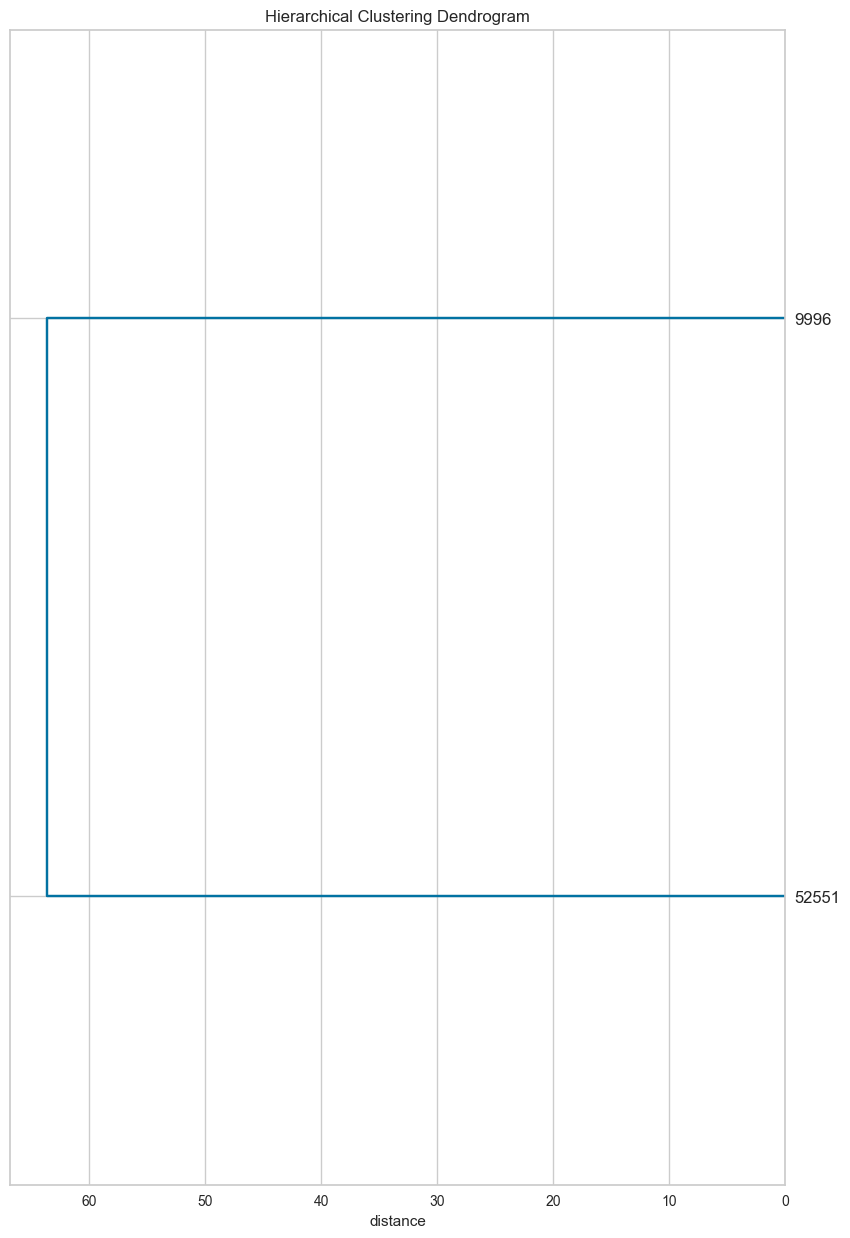

In [61]:
# Show a dendrogram, just for the first smallest cluster

sample = df_sampled_clustered[df_sampled_clustered.cluster == 2] # prendre le cluster 2 car celui avec le moins d'échantillons donc sera plus lisible
Z = linkage(sample, 'ward')
names = sample.index
plot_dendrogram(Z, names, figsize = (10, 15))

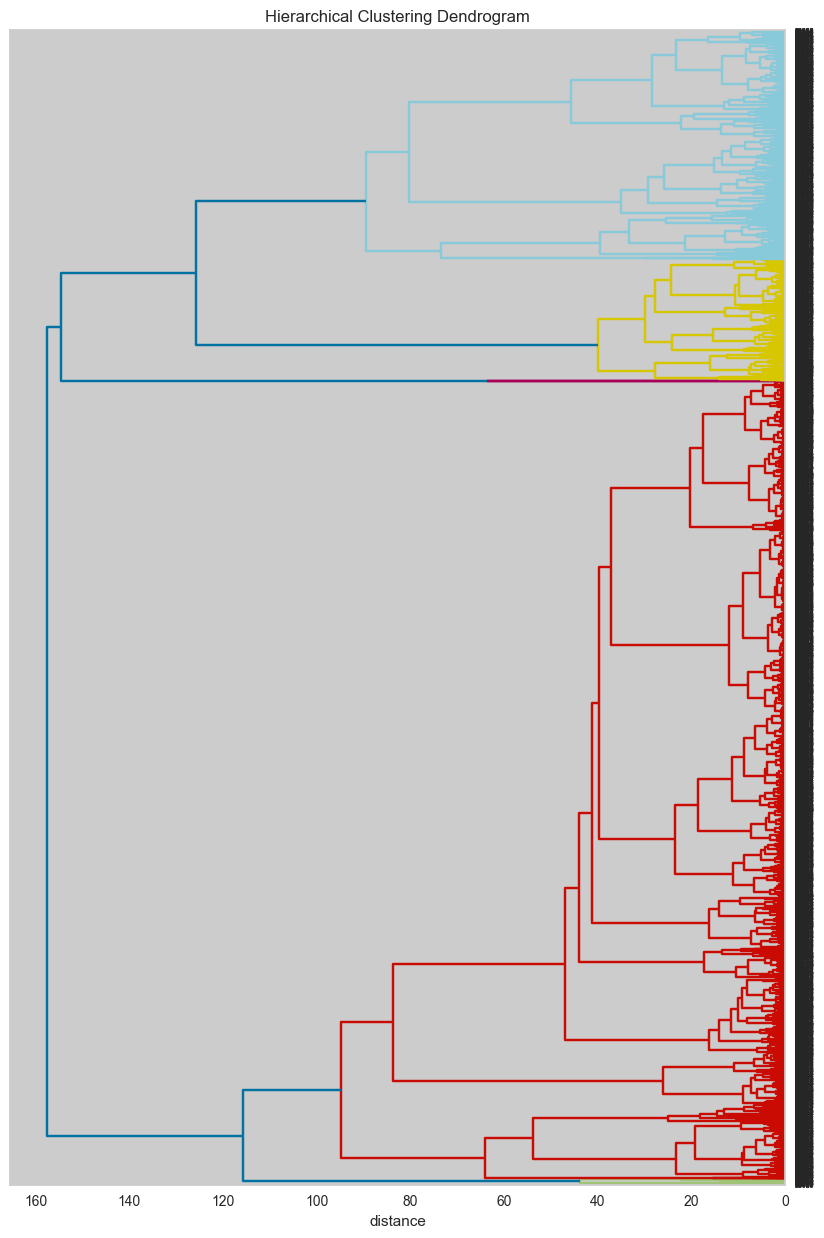

In [62]:
sample = df_sampled
Z = linkage(sample, 'ward')
names = sample.index
plot_dendrogram(Z, names, figsize = (10, 15))

In [63]:
# https://www.geeksforgeeks.org/implementing-agglomerative-clustering-using-sklearn/

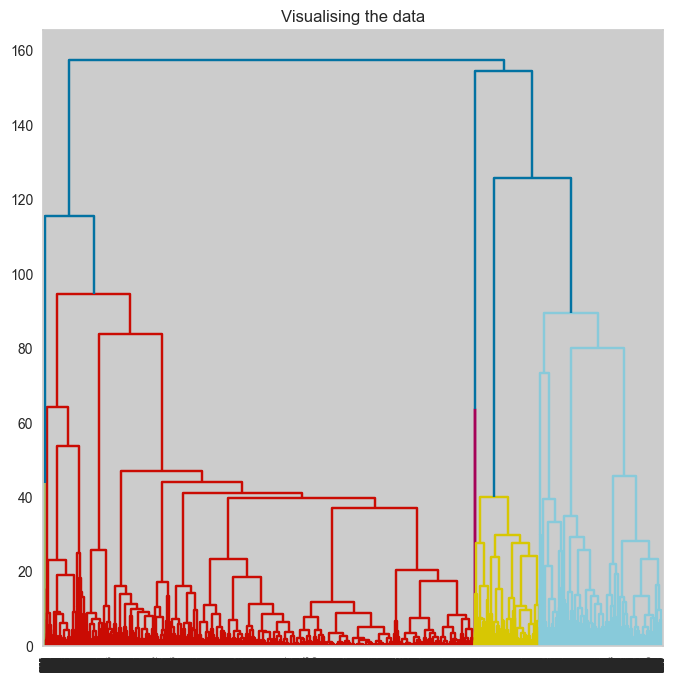

In [64]:

plt.figure(figsize = (8, 8))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(df_sampled, method = 'ward')))

In [ ]:
# résultat doit être à peu près similaire à ce qu'on option avec kmeans
# or on a du beaucoup réduire jeu de données donc trop contraignant donc pas adapté à notre situation donc on abandonne

In [ ]:
# REGARDER INFERENCE BAYESIENNE et voir si on ne peut pas faire ça ici

## DBSCAN

In [ ]:
# DBSCAN

# https://datascientest.com/machine-learning-clustering-dbscan#:~:text=Le%20DBSCAN%20est%20un%20algorithme%20simple%20qui%20d%C3%A9finit%20des%20clusters,estimation%20de%20la%20densit%C3%A9%20locale.
# Le DBSCAN est un algorithme simple qui définit des clusters en utilisant l’estimation de la densité locale

# https://www.reneshbedre.com/blog/dbscan-python.html

In [ ]:
# 1) calculer epsilon et min_samples

In [ ]:
# https://stackoverflow.com/questions/25633383/how-can-gridsearchcv-be-used-for-clustering-meanshift-or-dbscan

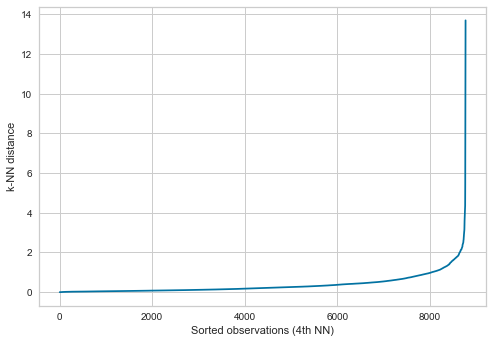

In [97]:

# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros)
nbrs = NearestNeighbors(n_neighbors = 3).fit(df_sampled)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(df_sampled)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis = 0)

k_dist = sort_neigh_dist[:, 2]
plt.plot(k_dist)
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

In [98]:

kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, S = 1.0,
                      curve = "concave", direction = "increasing", online=True)

# get the estimate of knee point
print(kneedle.knee_y)

2.610868153739761


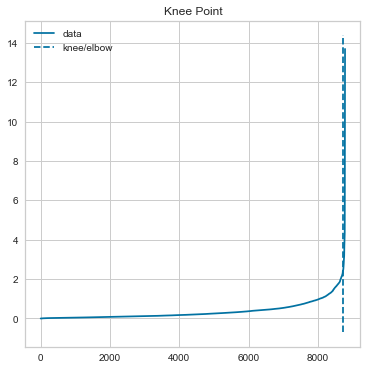

In [99]:
kneedle.plot_knee()
plt.show()

In [100]:
# utiliser cet optimum pour le dbscan clustering

eps = kneedle.knee_y

In [101]:
df_sampled.columns

Index(['Count', 'order_item_id', 'product_description_lenght',
       'product_weight_g', 'payment_sequential', 'payment_installments',
       'payment_value', 'review', 'cluster_num'],
      dtype='object')

In [102]:
# min_samples = 2 * number of dimensions

min_samples = 2 * df_sampled.shape[1]

# fixer min_samples à 100 -> sinon ne fait pas sens (on veut au moins 100 clients par cluster)
# essayer avec un min_samples à 10 et faire varier epsilon
# le but étant de montrer que pas adapté

In [103]:
# ATTENTION -> les clusters et les num de clusters sont dans le df ?????

# c'est quoi level_0 ???

In [104]:


db = DBSCAN(eps = eps, min_samples = min_samples).fit(df_sampled)

# get cluster labels
labels = db.labels_
labels

array([0, 0, 0, ..., 0, 0, 0])

In [105]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 86


In [106]:
# check unique clusters
set(labels) # -1 value represents noisy points could not assigned to any cluster

{-1, 0}

In [107]:
# Get each cluster size

Counter(labels)

Counter({0: 8691, -1: 86})

In [108]:
y_pred = DBSCAN(eps = eps, min_samples = min_samples).fit_predict(df_sampled)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [109]:
# Evaluation du clustering : silhouette score
silhouette_dbscan = round(silhouette_score(df_sampled, y_pred), 2)
print('The average silhouette score is:', silhouette_dbscan)

The average silhouette score is: 0.75


In [110]:
df_sampled

,Count,order_item_id,product_description_lenght,product_weight_g,payment_sequential,payment_installments,payment_value,review,cluster_num
15782,-0.276885,-0.294658,0.890359,2.817245,-0.129527,-0.710341,-0.013540,-0.785479,2
64125,-0.276885,-0.294658,0.820384,0.424020,-0.129527,-0.710341,0.101855,-0.785479,1
42631,-0.276885,-0.294658,-0.910660,-0.386908,-0.129527,0.491323,-0.657110,-0.785479,1
64203,-0.276885,-0.294658,-0.977302,0.621807,-0.129527,-0.710341,0.135877,-0.785479,1
4791,-0.276885,-0.294658,0.725418,0.700922,-0.129527,2.494097,0.056475,0.722476,2
...,...,...,...,...,...,...,...,...,...
44783,-0.276885,-0.294658,0.495501,-0.466023,-0.129527,-0.710341,-0.566505,0.722476,1
23929,-0.276885,-0.294658,-1.167234,-0.307793,-0.129527,1.292433,1.531100,-0.785479,2
34940,-0.276885,-0.294658,0.608794,-0.277334,-0.129527,0.090768,-0.343753,-0.785479,1
37920,-0.276885,-0.294658,-0.099285,-0.560961,-0.129527,0.891878,-0.256934,-0.785479,1


In [111]:
X = StandardScaler().fit_transform(df_sampled)

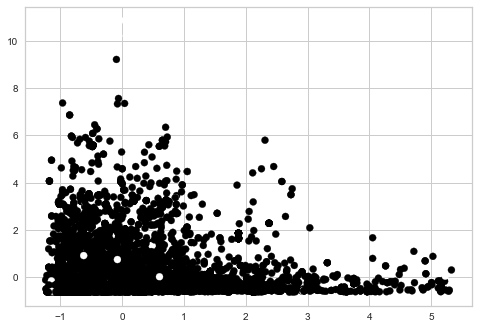

In [112]:
plt.figure()
plt.scatter(X[:, 2], X[:, 3],
            c = y_pred)
plt.show()

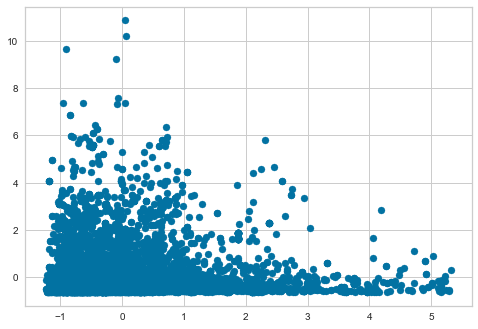

In [113]:
plt.figure()
plt.scatter(X[:, 2], X[:, 3])
plt.show()

In [114]:
plt.figure()
plt.scatter(df_sampled['payment_value'],
            df_sampled['product_category'],
            c = y_pred,
            cmap = plt.get_cmap('jet'))
plt.show()

KeyError: 'product_category'

<Figure size 576x396 with 0 Axes>

In [115]:
plt.figure()
p = sns.scatterplot(data = df_sampled,
                    x = 'purchase_day',
                    y = 'product_category',
                    hue = labels,
                    legend = 'full',
                    palette = 'deep')
sns.move_legend(p,
                'upper right',
                bbox_to_anchor = (1.17, 1.),
                title = 'Clusters')
plt.show()

ValueError: Could not interpret value `purchase_day` for parameter `x`

<Figure size 576x396 with 0 Axes>

In [136]:
# Optimisation en faisant une gridsearch

epsilon = np.linspace(0.01, 1, num = 20)
min_samples = np.arange(2, 25, step = 2)

import itertools
combinations = list(itertools.product(epsilon, min_samples))
N = len(combinations)
print(N)

def Gridsearch(combinations, X):
    scores = []
    all_label = []

    for i, (eps, num_samples) in enumerate(combinations):
        dbscan_model = DBSCAN(eps = eps, min_samples = num_samples).fit(X)
        labels = dbscan_model.labels_
        labels_set = set(labels)
        num_clusters = len(labels_set)
        if -1 in labels_set:
            num_clusters -= 1
        if (num_clusters < 2) or (num_clusters > 9):
            scores.append(-20)
            all_label.append('Poor')
            print(' at iteration : ', i, 'ep = ', eps, 'min_sample = ', num_samples, 'number of cluster = ', num_clusters, 'moving on...')
            continue
        scores.append(silhouette_score(X, labels))
        all_label.append(labels)
        print(' at iteration : ', i, 'score : ', scores[-1], 'Number of clusters :', num_clusters)
    best_index = np.argmax(scores)
    best_parameters = combinations[best_index]
    best_labels = all_label[best_index]
    best_score = scores[best_index]
    return {'best_epsilon' : best_parameters[0], 'best_min_samples' : best_parameters[1], 'best_labels' : best_labels, 'best_score' : best_score}


240


In [137]:
best_para = Gridsearch(combinations, df_reduit)

 at iteration :  0 ep =  0.01 min_sample =  2 number of cluster =  5759 moving on...
 at iteration :  1 ep =  0.01 min_sample =  4 number of cluster =  987 moving on...
 at iteration :  2 ep =  0.01 min_sample =  6 number of cluster =  399 moving on...
 at iteration :  3 ep =  0.01 min_sample =  8 number of cluster =  210 moving on...
 at iteration :  4 ep =  0.01 min_sample =  10 number of cluster =  126 moving on...
 at iteration :  5 ep =  0.01 min_sample =  12 number of cluster =  71 moving on...
 at iteration :  6 ep =  0.01 min_sample =  14 number of cluster =  53 moving on...
 at iteration :  7 ep =  0.01 min_sample =  16 number of cluster =  32 moving on...
 at iteration :  8 ep =  0.01 min_sample =  18 number of cluster =  22 moving on...
 at iteration :  9 ep =  0.01 min_sample =  20 number of cluster =  14 moving on...
 at iteration :  10 score :  -0.3764295569895561 Number of clusters : 7
 at iteration :  11 score :  -0.3764295569895561 Number of clusters : 7
 at iteration 

In [138]:
print(best_para)

{'best_epsilon': 0.01, 'best_min_samples': 22, 'best_labels': array([-1, -1, -1, ..., -1, -1, -1]), 'best_score': -0.3764295569895561}


In [139]:
df_reduit['cluster'] = best_para['best_labels']

In [140]:
df_reduit['cluster'].value_counts()

-1    87554
 3       40
 0       39
 1       38
 2       26
 6       24
 5       24
 4       24
Name: cluster, dtype: int64

In [141]:
df_reduit['cluster'].unique()

array([-1,  6,  0,  1,  2,  5,  4,  3])

In [ ]:
# pas vraiment compris le 'min samples'.... à creuser

## Spectral clustering

In [ ]:
# https://www.kaggle.com/code/vipulgandhi/spectral-clustering-detailed-explanation

In spectral clustering, data points are treated as nodes of a graph. Thus, spectral clustering is a graph partitioning problem. The nodes are then mapped to a low-dimensional space that can be easily segregated to form clusters. No assumption is made about the shape/form of the clusters. The goal of spectral clustering is to cluster data that is connected but not necessarily compact or clustered within convex boundaries.

Spectral Clustering vs. Kmeans
Compactness — Points that lie close to each other fall in the same cluster and are compact around the cluster center. The closeness can be measured by the distance between the observations. E.g.: K-Means Clustering
Connectivity — Points that are connected or immediately next to each other are put in the same cluster. Even if the distance between 2 points is less, if they are not connected, they are not clustered together. Spectral Clustering is a technique that follows this approach.



In [ ]:
# https://www.geeksforgeeks.org/ml-spectral-clustering/
#### à lire

In [ ]:
# souvent utilisé après une ACP comme ça les données sont visualisées en 2D (en gardant 2 composantes uniquement) donc plus facile d'évaluer perf du clustering
# (comme pour tous les algo en fait...)

In [ ]:
# complexité algorithmique : O(n3)
# -> utiliser le df_sampled

In [ ]:
# Comment définir nb de cluster optimal ?

In [107]:
%%time
# affinity matrix avec kernel Gaussien
# -> 'affinity' = 'rbf'

# Building the clustering model
spectral_model_rbf = SpectralClustering(n_clusters = 4, affinity = 'rbf')

# Training the model and Storing the predicted cluster labels
labels_rbf = spectral_model_rbf.fit_predict(df_sampled)

CPU times: user 9min 5s, sys: 11.3 s, total: 9min 16s
Wall time: 1min 17s


In [108]:
# Evaluation du clustering : silhouette score
silhouette_spectral_rbf = round(silhouette_score(df_sampled, labels_rbf), 2)
print('The average silhouette score is:', silhouette_spectral_rbf)

The average silhouette score is: 0.87


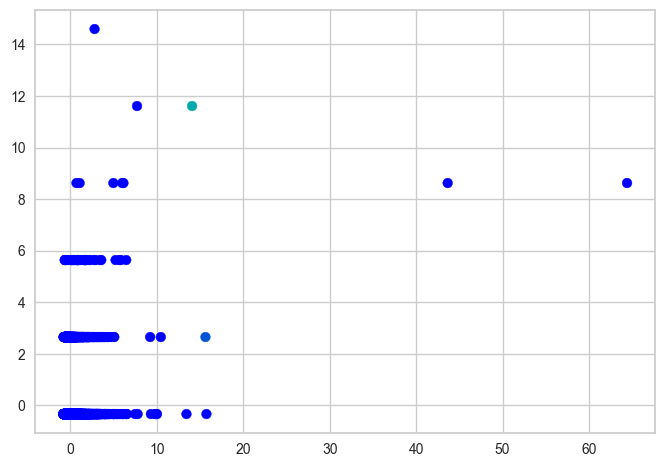

In [110]:
# Visualizing the clustering
plt.figure()
plt.scatter(
    df_sampled['payment_value'],
    df_sampled['review'],
    c = SpectralClustering(n_clusters = 4, affinity = 'rbf').fit_predict(df_sampled),
    cmap = plt.cm.winter
    )
plt.show()

In [111]:
%%time
# -> affinity = ‘nearest_neighbors’

# Building the clustering model
spectral_model_nn = SpectralClustering(n_clusters = 2, affinity ='nearest_neighbors')

# Training the model and Storing the predicted cluster labels
labels_nn = spectral_model_nn.fit_predict(df_sampled)

CPU times: user 15.6 s, sys: 546 ms, total: 16.2 s
Wall time: 2.36 s


In [112]:
# Evaluation du clustering : silhouette score
silhouette_spectral_nn = round(silhouette_score(df_sampled, labels_nn), 2)
print('The average silhouette score is:', silhouette_spectral_nn)

The average silhouette score is: 0.36


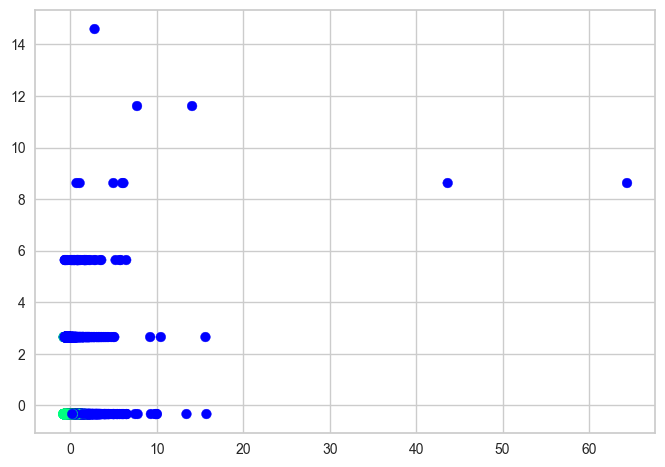

In [113]:
# Visualizing the clustering
plt.figure()
plt.scatter(df_sampled['payment_value'],
            df_sampled['review'],
            c = SpectralClustering(n_clusters = 2, affinity = 'nearest_neighbors').fit_predict(df_sampled),
            cmap = plt.cm.winter)
plt.show()

In [115]:
# Evaluer performances (sur dataset avant sampling ? )

# List of different values of affinity
affinity = ['rbf', 'nearest-neighbours']

# List of Silhouette Scores
s_scores = []

# Evaluating the performance
s_scores.append(silhouette_score(df_sampled, labels_rbf))
s_scores.append(silhouette_score(df_sampled, labels_nn))

print(s_scores)

[0.8703447926031176, 0.3595523085249755]


In [ ]:
# Comparer performance des différents algo

# https://saturncloud.io/blog/performance-analysis-of-clustering-algorithms/#:~:text=The%20adjusted%20Rand%20index%20(ARI,value%20indicates%20better%20clustering%20performance.
# https://stats.stackexchange.com/questions/95782/what-are-the-most-common-metrics-for-comparing-two-clustering-algorithms-especi

# ARI Score

In [116]:
# tester stabilité de la segmentation client dans le temps et voir à quel moment les clients changent de cluster
# pour ça, on réitère les étapes précedantes sur des périodes décalées dans le temps de 30j, 60j, 90j...

# The higher the ARI value, the closer the two clusterings are to each other. 
# It ranges from -1 to 1, where 1 indicates perfect agreement between the two clusterings, 
# 0 indicates a random agreement and -1 indicates that the two clusterings are completely different

In [117]:
df_clusters.columns

Index(['Count', 'order_item_id', 'product_description_lenght',
       'product_weight_g', 'payment_sequential', 'payment_installments',
       'payment_value', 'review', 'cluster_num'],
      dtype='object')

In [118]:
# concat avec date
df_ari = pd.concat([df_clusters, df_final['Date_achat']], axis = 1)
df_ari

,Count,order_item_id,product_description_lenght,product_weight_g,payment_sequential,payment_installments,payment_value,review,cluster_num,Date_achat
0,-0.277408,1.395281,-0.700400,0.051337,-0.13044,-0.709001,-0.096009,-0.331713,0,2017-11-30
1,-0.277408,-0.290293,0.292874,-0.291392,-0.13044,-0.709001,-0.552778,-0.331713,0,2017-10-29
2,-0.277408,-0.290293,-0.370989,-0.564939,-0.13044,0.085830,-0.653538,2.654219,1,2018-05-07
3,-0.277408,-0.290293,1.188669,-0.234138,-0.13044,2.072909,-0.062612,-0.331713,2,2017-08-27
4,-0.277408,-0.290293,2.934881,-0.604699,-0.13044,-0.709001,-0.726702,-0.331713,0,2017-01-05
...,...,...,...,...,...,...,...,...,...,...
87094,0.950211,2.238068,-0.317208,0.309775,-0.13044,-0.311585,1.268967,5.640151,1,2018-04-30
87095,-0.277408,-0.290293,-1.172667,0.468814,-0.13044,-0.311585,-0.601271,-0.331713,0,2017-12-15
87096,-0.277408,-0.290293,-1.071827,-0.386020,-0.13044,-0.311585,-0.570279,2.654219,1,2018-05-07
87097,-0.277408,-0.290293,-0.720568,-0.457190,-0.13044,0.880662,1.400766,-0.331713,2,2017-06-15


In [119]:
# order by date et reset index

df_ari.sort_values(['Date_achat'], inplace = True)
df_ari

,Count,order_item_id,product_description_lenght,product_weight_g,payment_sequential,payment_installments,payment_value,review,cluster_num,Date_achat
78283,-0.277408,-0.290293,-0.856702,0.071217,-0.13044,0.085830,-0.383996,-0.331713,0,2016-10-03
19745,0.950211,-0.290293,0.863460,-0.554999,-0.13044,-0.112877,0.690352,-0.331713,0,2016-10-03
28527,-0.277408,-0.290293,-0.402922,-0.485420,-0.13044,-0.709001,-0.634858,-0.331713,0,2016-10-03
18431,-0.277408,1.395281,3.281098,-0.246861,-0.13044,1.675493,-0.113841,-0.331713,2,2016-10-04
16734,-0.277408,-0.290293,-0.838215,-0.401924,-0.13044,2.867740,0.442556,-0.331713,2,2016-10-04
...,...,...,...,...,...,...,...,...,...,...
32193,-0.277408,-0.290293,0.620604,-0.465540,-0.13044,-0.709001,-0.377015,-0.331713,0,2018-08-29
19940,-0.277408,-0.290293,2.778579,-0.493372,-0.13044,-0.709001,-0.469189,2.654219,1,2018-08-29
32993,-0.277408,-0.290293,-0.394519,-0.346261,-0.13044,-0.311585,-0.255923,-0.331713,0,2018-08-29
74572,-0.277408,-0.290293,-0.216368,-0.529155,-0.13044,-0.709001,0.021591,-0.331713,0,2018-08-29


In [120]:
df_ari.reset_index(drop = True, inplace = True)

In [121]:
# définir timedelta

# premier date dispo = 03/10/2016
# dernière date dispo = 29/08/2018

# quasiment 2ans de données
# timedelta = prendre 6 mois glissants ? 180j

# écart entre les dates et les lignes n'est pas constant donc passer automatiquement pas les dates

date_debut = pd.to_datetime('2016-10-03')
date_fin = date_debut + pd.Timedelta(days = 180)
print(date_fin)

# filtrer jeu de données
filter_date = (df_ari['Date_achat'] > date_debut) & (df_ari['Date_achat'] < date_fin) 
df_date = df_ari[filter_date].copy()
df_date

2017-04-01 00:00:00


,Count,order_item_id,product_description_lenght,product_weight_g,payment_sequential,payment_installments,payment_value,review,cluster_num,Date_achat
3,-0.277408,1.395281,3.281098,-0.246861,-0.13044,1.675493,-0.113841,-0.331713,2,2016-10-04
4,-0.277408,-0.290293,-0.838215,-0.401924,-0.13044,2.867740,0.442556,-0.331713,2,2016-10-04
5,-0.277408,-0.290293,-0.868467,0.071217,-0.13044,-0.311585,-0.528485,-0.331713,0,2016-10-04
6,-0.277408,1.395281,-0.838215,-0.048063,-0.13044,2.867740,-0.340739,-0.331713,2,2016-10-04
7,-0.277408,-0.290293,1.050854,0.091096,-0.13044,-0.709001,-0.312577,-0.331713,0,2016-10-04
...,...,...,...,...,...,...,...,...,...,...
4802,-0.277408,-0.290293,-0.517207,2.933917,-0.13044,-0.311585,-0.690616,-0.331713,2,2017-03-31
4803,-0.277408,-0.290293,-0.636535,-0.435720,-0.13044,0.085830,-0.651746,-0.331713,0,2017-03-31
4804,-0.277408,-0.290293,-0.260065,1.721245,-0.13044,0.483246,1.186510,-0.331713,2,2017-03-31
4805,-0.277408,-0.290293,0.012203,1.097415,-0.13044,2.072909,2.702861,-0.331713,2,2017-03-31


In [122]:
# garder les clients quand j'avance dans le temps -> un client acquis reste acquis 
# fixer base de clients (6mois) et ajouter des nouveaux clients - ne pas en enlever

In [123]:
df_date.columns

Index(['Count', 'order_item_id', 'product_description_lenght',
       'product_weight_g', 'payment_sequential', 'payment_installments',
       'payment_value', 'review', 'cluster_num', 'Date_achat'],
      dtype='object')

In [124]:
# surtout ajout de nouveaux clients - actuels clients pas susceptibles de changer de comportement
# prendre intervalle de base suffisamment grand et glisser dans le temps pour voir impact de l'arrivée de nouveaux clients sur nos clusters

# sujet sur l'integration des nouveaux clients dans le calcul du score ARI
# calculer score ari par rapport à t0

2017-04-01 00:00:00


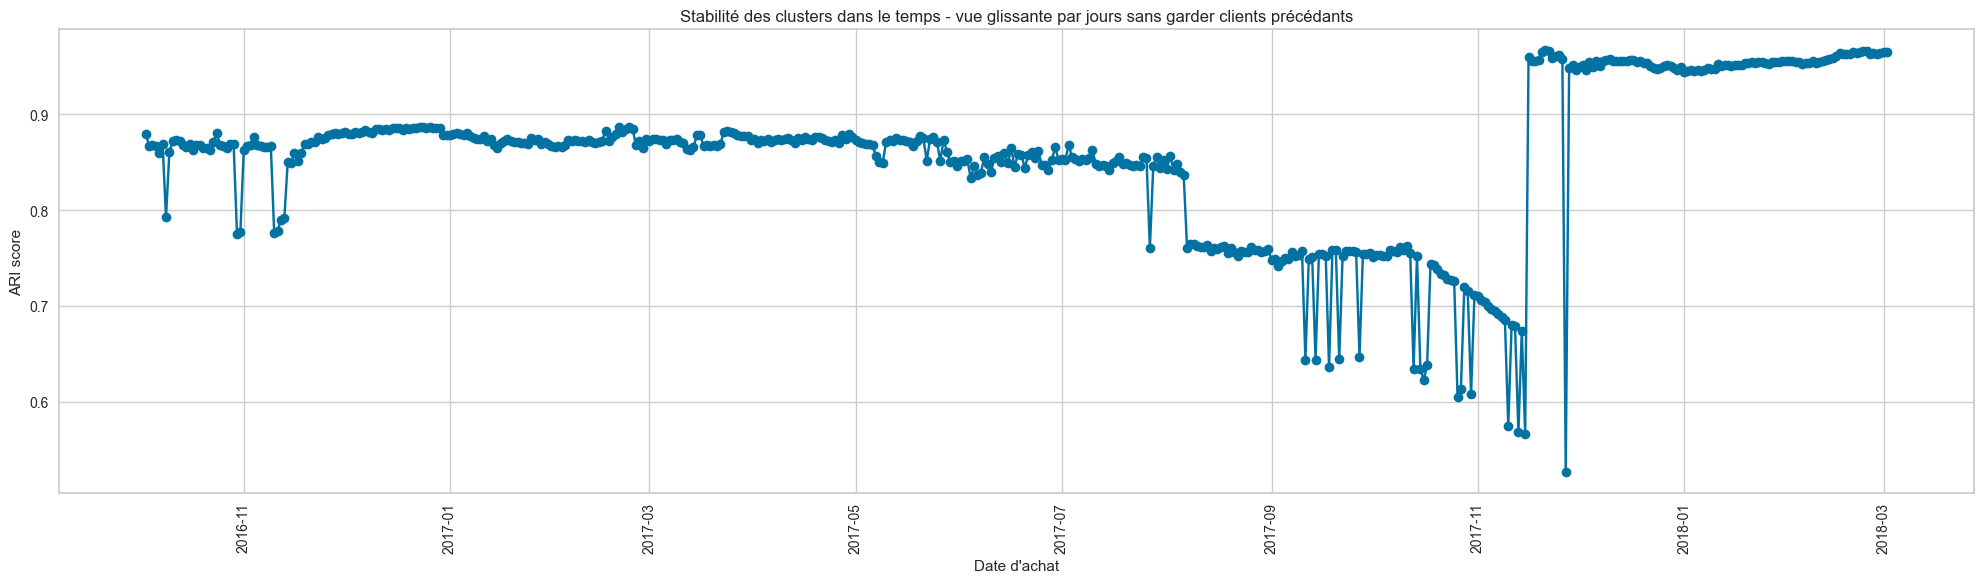

CPU times: user 18min 57s, sys: 3min 12s, total: 22min 10s
Wall time: 2min 54s


In [125]:
%%time

# ari score -> labels true vs labels pred

# dernière date dispo = 29/08/2018
last_day = pd.to_datetime('2018-08-29')

# intervalle de temps
date_debut = pd.to_datetime('2016-10-03')
date_fin = date_debut + pd.Timedelta(days = 180)
print(date_fin)

# liste vide pour stocker ari score et première date de chaque paquet de données
ari_values = []
date_achat = []

# avancer d'un jour dans le temps jusqu'à ce qu'on atteigne la dernière date du jeu de données
while date_fin <= last_day:
    date_achat.append(date_debut)

    # filtrer dates et prendre 6 mois de données
    #filter_date = (df_ari['Date_achat'] > date_debut) & (df_ari['Date_achat'] < date_fin) 
    #df_date = df_ari[filter_date].copy()
    df_date = df_ari.loc[(df_ari['Date_achat'] > date_debut) & (df_ari['Date_achat'] < date_fin)]

    # 'stocker' labels des clusters (pour ensuite comparer aux labels qu'on va prédire)
    labels_true = df_date['cluster_num']

    # copier le jeu de données sans prendre le nombre de clusters ni la date
    #data_cluster = df_date[['Count', 'order_item_id', 'product_description_lenght', 'product_weight_g',
    #   'payment_sequential', 'payment_installments', 'payment_value', 'review']].copy()

    data_cluster = df_date.drop(['Date_achat', 'cluster_num'], axis = 1)

    # kmeans
    km = KMeans(n_clusters = 3)
    km.fit(data_cluster)

    # prédire clusters
    labels_pred = km.predict(data_cluster)

    # calcul ari score
    ari = adjusted_rand_score(labels_true, labels_pred)
    ari_values.append(ari)

    # incrément d'un jour
    date_debut += timedelta(days = 1)
    date_fin += timedelta(days = 1)

# Figure résultat
plt.figure(figsize = (20, 6))
plt.plot(date_achat, ari_values, marker = 'o', linestyle = '-')
plt.title('Stabilité des clusters dans le temps - vue glissante par jours sans garder clients précédants')
plt.xlabel("Date d'achat")
plt.ylabel('ARI score')
plt.xticks(rotation = 90)
#plt.ylim((0, 1)) # pour avoir une échelle 0 - 1 sur l'axe y
plt.grid(True)
plt.tight_layout()
plt.show()


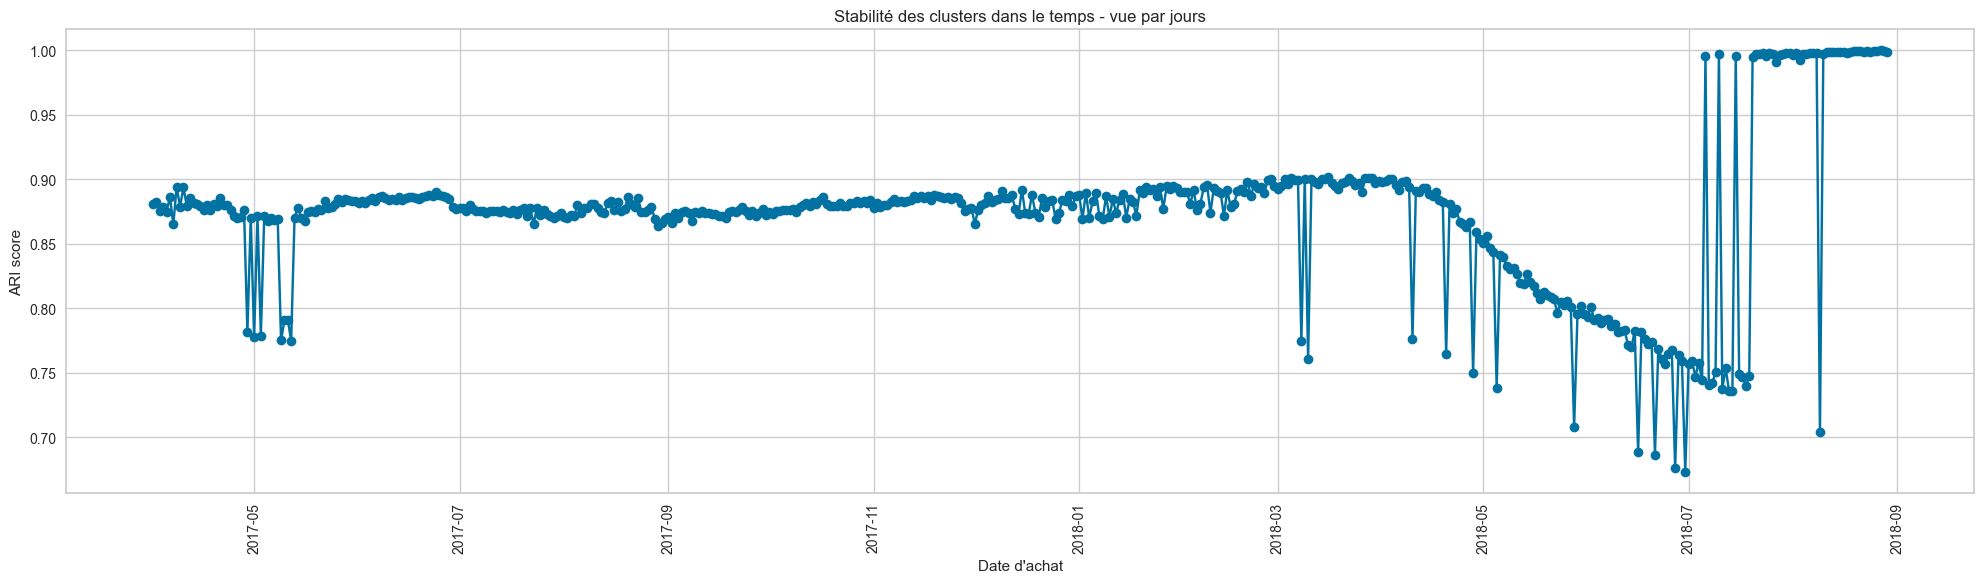

CPU times: user 23min 6s, sys: 4min 10s, total: 27min 17s
Wall time: 3min 32s


In [127]:
%%time

# Même chose en comparant avec t0

# dernière date dispo = 29/08/2018
last_day = pd.to_datetime('2018-08-29')

# intervalle de temps
date_debut = pd.to_datetime('2016-10-03')
date_fin = date_debut + pd.Timedelta(days = 180)

# liste vide pour stocker ari score
ari_values = []
date_achat = []

while date_fin <= last_day:
    date_achat.append(date_fin)

    # filtrer dates et prendre 6 mois de données
    filter_date = (df_ari['Date_achat'] < date_fin) 
    df_date = df_ari[filter_date].copy()

    # 'stocker' labels des clusters (pour ensuite comparer aux labels qu'on va prédire)
    labels_true = df_date['cluster_num']

    # copier le jeu de données sans prendre le nombre de clusters ni la date
    data_cluster = df_date[['Count', 'order_item_id', 'product_description_lenght', 'product_weight_g',
       'payment_sequential', 'payment_installments', 'payment_value', 'review']].copy()
    # kmeans
    km = KMeans(n_clusters = 3)
    km.fit(data_cluster)

    # prédire clusters
    labels_pred = km.predict(data_cluster)

    # calcul ari score
    ari = adjusted_rand_score(labels_true, labels_pred)
    ari_values.append(ari)

    # incrément d'un jour (pour la date de fin seulement)
    date_debut += timedelta(days = 1)
    date_fin += timedelta(days = 1)

plt.figure(figsize = (20, 6))
plt.plot(date_achat, ari_values, marker = 'o', linestyle = '-')
plt.title('Stabilité des clusters dans le temps - vue par jours')
plt.xlabel("Date d'achat")
plt.ylabel('ARI score')
plt.xticks(rotation = 90)
#plt.ylim((0, 1)) # pour avoir une échelle 0 - 1 sur l'axe y
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Changer dates -> prendre date de 'fin' de mes 6 mois et non date de début
# instabilité de survient que fin 2017 -> changement de comportements ou base devient trop grande - base de clients suffisamment représentative ? en élargissant la taille de la base client de ref, est-ce que l'instabilité arrive plus tôt ? (prendre plus que 6mois) plus la base client sera grande, plus on va se rapprocher des conditions réelles et plus ça sera intéressant
# faire quelques tests de taille de base de réference

# comment choisir seuil de rafraichissement ?
# dans la réalité, il faudrait croiser évolution du score ari avec données campagnes marketing

# voir slack

In [ ]:
# forte inflexion après 1 an sur les clients initiaux. Il faudra donc prévoir la maintenance du programme de segmentation et une redéfinition des clusters de clients au minimum tous les ans pour garantir un résultat optimal. 

In [ ]:
# question : pas de différence entre les deux tests (depuis t0 et en glissant dans le temps) -> donc a priori la conservation ou non des clients déjà acquis n'influence pas la stabilité du clustering

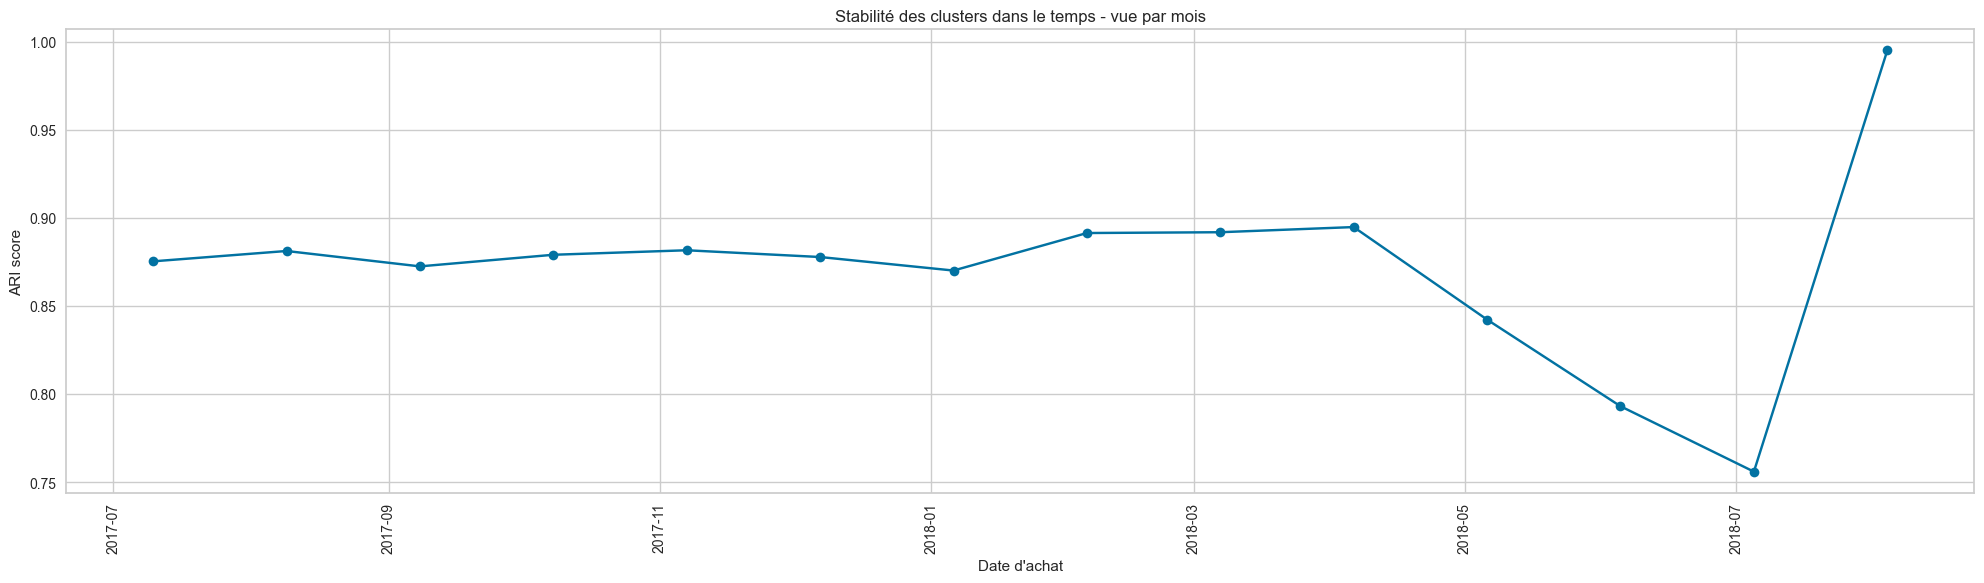

CPU times: user 48.5 s, sys: 8.49 s, total: 57 s
Wall time: 7.54 s


In [128]:
%%time

# Même chose en changeant d'echelle (mois)
# (comparaison t0)

# dernière date dispo = 29/08/2018
last_day = pd.to_datetime('2018-08-29')

# intervalle de temps
date_debut = pd.to_datetime('2016-10-03')
date_fin = date_debut + pd.Timedelta(days = 280)

# liste vide pour stocker ari score
ari_values = []
date_achat = []

while date_fin <= last_day:
    date_achat.append(date_fin)

    # filtrer dates et prendre 6 mois de données
    filter_date = (df_ari['Date_achat'] < date_fin) 
    df_date = df_ari[filter_date].copy()

    # 'stocker' labels des clusters (pour ensuite comparer aux labels qu'on va prédire)
    labels_true = df_date['cluster_num']

    # copier le jeu de données sans prendre le nombre de clusters ni la date
    data_cluster = df_date[['Count', 'order_item_id', 'product_description_lenght', 'product_weight_g',
       'payment_sequential', 'payment_installments', 'payment_value', 'review']].copy()
    # kmeans
    km = KMeans(n_clusters = 3)
    km.fit(data_cluster)

    # prédire clusters
    labels_pred = km.predict(data_cluster)

    # calcul ari score
    ari = adjusted_rand_score(labels_true, labels_pred)
    ari_values.append(ari)

    # incrément d'un jour (pour la date de fin seulement)
    date_fin += timedelta(days = 30)

plt.figure(figsize = (20, 6))
plt.plot(date_achat, ari_values, marker = 'o', linestyle = '-')
plt.title('Stabilité des clusters dans le temps - vue par mois')
plt.xlabel("Date d'achat")
plt.ylabel('ARI score')
# afficher score sur graph
plt.xticks(rotation = 90)
#plt.ylim((0, 1)) # pour avoir une échelle 0 - 1 sur l'axe y
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# première inflexion -> pas assez de données pour que clustering soit robuste -> à ignorer
# seconde inflexion autour d'octobre 2017 (au bout d'un an) - confirme hypothèse de la vue par jour

# remontée finale -> ajout de clients qui recollent au clustering initial

# regarder aussi par semaine
# jouer avec taille de base clients de référence

In [ ]:
%%time

# Même chose en reculant dans le temps

# dernière date dispo = 29/08/2018
#first_day = pd.to_datetime('2016-10-03')
first_day = pd.to_datetime('2016-11-15')

# intervalle de temps
date_fin = pd.to_datetime('2018-08-29')
date_debut = date_fin - pd.Timedelta(days = 180)
print(date_debut)
date_data = date_debut

# liste vide pour stocker ari score
ari_values = []
date_achat = []

while date_debut > first_day:
    date_achat.append(date_data)

    # filtrer dates et prendre 6 mois de données
    filter_date = (df_ari['Date_achat'] > date_debut)
    df_date = df_ari[filter_date].copy()

    # 'stocker' labels des clusters (pour ensuite comparer aux labels qu'on va prédire)
    labels_true = df_date['cluster_num']

    # copier le jeu de données sans prendre le nombre de clusters ni la date
    data_cluster = df_date[['Count', 'order_item_id', 'product_description_lenght', 'product_weight_g',
       'payment_sequential', 'payment_installments', 'payment_value', 'review']].copy()

    # kmeans
    km = KMeans(n_clusters = 3)
    km.fit(data_cluster)

    # prédire clusters
    labels_pred = km.predict(data_cluster)

    # calcul ari score
    ari = adjusted_rand_score(labels_true, labels_pred)
    ari_values.append(ari)

    # décrément d'un jour (pour 'reculer' dans le temps)
    date_data -= timedelta(days = 30)

# Figure
plt.figure(figsize = (20, 6))
plt.plot(date_achat, ari_values, marker = 'o', linestyle = '-')
plt.title('Cluster Stability Over Time')
plt.xlabel("Date d'achat")
plt.ylabel('ARI score')
plt.xticks(rotation = 90)
#plt.ylim((0, 1)) # pour avoir une échelle 0 - 1 sur l'axe y
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# articles à regarder :

# CLTV
# https://medium.com/@abdullahorzan/data-driven-customer-segmentation-rfm-and-cltv-analysis-using-python-4238b11bd740

# marketing campaign analysis
# https://medium.com/@cakrasinaga/marketing-campaign-analysis-52747f138e93

In [ ]:
#https://github.com/MGL56/Projet_4/blob/master/Projet_4.ipynb

# Diagramme de Sankey

# voir quantité de personnes qui passent d'un cluster à un autre
# à creuser seulement si j'ai du temps

In [ ]:
# axe de reflexion (mais à ne pas faire ici) -> mettre à jour la base client au fur et à mesure de l'avancée dans le temps pour les clients qui font plusieurs commandes

# bien figer le random state et juste itérer dans le temps
# ne pas itérer en faisant plusieurs clustering sur le même temps 

In [ ]:
# Ressources intéressantes : 

# https://amueller.github.io/aml/04-model-evaluation/17-cluster-evaluation.html ###### meh
# https://github.com/FlorentF9/skstab ### non - module python pour évaluer stabilité des clusters mais pas dans le temps
# https://reval.readthedocs.io/en/latest/ ### meh
# https://www.kaggle.com/code/hamadizarrouk/segmentation-des-clients-d-un-site-e-commerce-nb2#Stabilit%C3%A9-temporelle-de-la-segmentation
